In [11]:
import glob
import os
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, \
    classification_report, confusion_matrix
import seaborn as sns
import joblib
from scipy.ndimage import binary_dilation, binary_erosion, label, generate_binary_structure
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [12]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

image_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\train\\clipped_images"
shapefile_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\train\\clipped_train"
unlabeled_image_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\train\\clipped_unlabeled"
new_walrus_dir = "E:\\PycharmProjects\\nina\\walrus\\data\\walrus_shapefiles"


# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")


# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


all_image_paths = image_paths + unlabeled_image_paths

def pair_files(image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs


def pair_training_files(image_paths, shapefile_paths):
    training_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if matching_shapefiles:
            training_pairs[image_path] = matching_shapefiles[0]

    return training_pairs


def pair_validation_files(unlabeled_image_paths, walrus_paths):
    validation_pairs = {}
    for image_path in unlabeled_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        if matching_walrus:
            validation_pairs[image_path] = matching_walrus[0]
        else:
            validation_pairs[image_path] = None  # Include images without walrus shapefiles

    return validation_pairs


training_pairs = pair_training_files(image_paths, shapefile_paths)
validation_pairs = pair_validation_files(unlabeled_image_paths, new_walrus_paths)
file_pairs = pair_files(image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    features, labels, img_name = np.array(features), np.array(labels), np.array(img_name)

    # Debugging print statements
    print(f"Extracted {features.shape[0]} features, {labels.shape[0]} labels from {image_path}")

    return features, labels, img_name


def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile, None)
        if img_features.size > 0:
            features.append(img_features)
            labels.append(img_labels)
            image_name.append(img_name)

    if features and labels:
        features = np.vstack(features)
        labels = np.hstack(labels)
        image_name = np.hstack(image_name)
    else:
        features = np.array(features)
        labels = np.array(labels)
        image_name = np.array(image_name)

    print(f"Total features: {features.shape}, Total labels: {labels.shape}, Total image names: {image_name.shape}")

    return features, labels, image_name


features, labels, image_name = get_dataset(training_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})
# Combine classes
dataset['combined_labels'] = dataset['labels'].apply(lambda x: 'land' if x in ['rock', 'ice', 'freshwater'] else (
    'walrus' if x in ['walrus_pure', 'walrus_mixed'] else x))
combined_le = LabelEncoder()
dataset['combined_encoded_labels'] = combined_le.fit_transform(dataset['combined_labels'])

Extracted 118050 features, 118050 labels from E:\PycharmProjects\nina\walrus\data\train\clipped_images\buch_20230714_image.tif
Extracted 186702 features, 186702 labels from E:\PycharmProjects\nina\walrus\data\train\clipped_images\buch_20230720_image.tif
Extracted 174450 features, 174450 labels from E:\PycharmProjects\nina\walrus\data\train\clipped_images\buch_20230731_image.tif
Extracted 74527 features, 74527 labels from E:\PycharmProjects\nina\walrus\data\train\clipped_images\buch_20230923_image.tif
Extracted 67507 features, 67507 labels from E:\PycharmProjects\nina\walrus\data\train\clipped_images\moff_20230717_image.tif
Extracted 63726 features, 63726 labels from E:\PycharmProjects\nina\walrus\data\train\clipped_images\pal_20230714_image.tif
Extracted 28744 features, 28744 labels from E:\PycharmProjects\nina\walrus\data\train\clipped_images\pal_20230720_image.tif
Extracted 78019 features, 78019 labels from E:\PycharmProjects\nina\walrus\data\train\clipped_images\pal_20230726_image.t

In [13]:
def custom_train_test_split(df, label_col='combined_encoded_labels', test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1 / test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df[label_col]):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]

        # Ensure that rare classes are in the training set
        if not all(cls in train_df[label_col].values for cls in [combined_le.transform(['walrus'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in
               unique_islands):
            print(f"Train set size: {train_df.shape}, Test set size: {test_df.shape}")
            return train_df, test_df
    return None, None


train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')

# Split the data
train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')
X_train, y_train = train_df.drop(
    columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, train_df[
    'combined_encoded_labels'].values
X_test, y_test = test_df.drop(
    columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, test_df[
    'combined_encoded_labels'].values


Train set size: (970828, 13), Test set size: (242707, 13)
Train set size: (970828, 13), Test set size: (242707, 13)


In [16]:
# Separate features for ocean vs. not ocean and land vs. walrus
X_train_ocean = X_train[:, 3:]  # Last 5 bands for ocean vs. not ocean
X_test_ocean = X_test[:, 3:]
X_train_walrus = X_train[:, :5]  # First 5 bands for land vs. walrus
X_test_walrus = X_test[:, :5]

# Train the binary classifier (ocean vs. not ocean)
binary_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

binary_model.fit(X_train_ocean, y_train)

# Debugging print statements
print(f"Binary model trained on {X_train_ocean.shape} features")

# Save the binary model
binary_model_filename = "binary_ocean_not_ocean_model5.joblib"
joblib.dump(binary_model, binary_model_filename)

Binary model trained on (970828, 5) features


In [ ]:
# This for grid search uncomment if you wish to run it
# from sklearn.model_selection import  GridSearchCV
# not_ocean_mask = train_df['combined_labels'] == 'land'
# X_train_not_ocean = X_train_walrus[not_ocean_mask]
# y_train_not_ocean = train_df.loc[not_ocean_mask, 'encoded_labels'].values
# 
# # Train the walrus classifier (land vs. walrus)
# walrus_model = VotingClassifier(estimators=[
#     ('knn', KNeighborsClassifier()),
#     ('rf', RandomForestClassifier(random_state=42)),
#     ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
# ], voting='soft')
# 
# non_ocean_mask_train = y_train != combined_le.transform(['ocean'])[0]
# params = {"knn__leaf_size": range(10, 50), "rf__n_estimator": range(20, 200, 20), "xgb__n_estimators": range(20, 200, 20)}
# grid_walrus_model = GridSearchCV(estimator=walrus_model, param_grid=params, n_jobs=-4, verbose=4)
# grid_walrus_model = grid_walrus_model.fit(X_train_walrus[non_ocean_mask_train], y_train[non_ocean_mask_train])
# 
# # Debugging print statements
# print(f"Walrus model trained on {X_train_walrus[non_ocean_mask_train].shape} features")
# 
# # Save the walrus model
# walrus_model_filename = "walrus_vs_land_model5_gird_search.joblib"
# joblib.dump(grid_walrus_model, walrus_model_filename)

# gave: {'knn__leaf_size': 10, 'rf__n_estimators': 80, 'xgb__n_estimators': 20}

In [19]:
# Filter land and walrus pixels for training
not_ocean_mask = train_df['combined_labels'] == 'land'
X_train_not_ocean = X_train_walrus[not_ocean_mask]
y_train_not_ocean = train_df.loc[not_ocean_mask, 'encoded_labels'].values

# Train the walrus classifier (land vs. walrus)
walrus_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

non_ocean_mask_train = y_train != combined_le.transform(['ocean'])[0]
walrus_model.fit(X_train_walrus[non_ocean_mask_train], y_train[non_ocean_mask_train])

# Debugging print statements
print(f"Walrus model trained on {X_train_walrus[non_ocean_mask_train].shape} features")

# Save the walrus model
walrus_model_filename = "walrus_vs_land_model5.joblib"
joblib.dump(walrus_model, walrus_model_filename)

Walrus model trained on (347398, 5) features


['walrus_vs_land_model5.joblib']

In [17]:
# Function to remove small isolated pixels for specific target labels only
def connected_component_analysis(prediction, min_size=50, target_labels=[]):
    cleaned_prediction = np.copy(prediction)
    for target_label in target_labels:
        mask = prediction == target_label
        labeled_array, num_features = label(mask)
        sizes = np.bincount(labeled_array.ravel())
        mask_sizes = sizes >= min_size
        mask_sizes[0] = 0  # Ensure background is not considered
        cleaned_mask = mask_sizes[labeled_array]
        cleaned_prediction[mask & ~cleaned_mask] = 0  # Set the speckles to background (0)
    return cleaned_prediction


# Function to remove speckles using morphological operations for specific target labels only
def remove_speckles(prediction, structure_size=3, target_labels=[]):
    cleaned_prediction = np.copy(prediction)
    for target_label in target_labels:
        mask = prediction == target_label
        structure = generate_binary_structure(2, 1)
        eroded = binary_erosion(mask, structure=structure, iterations=structure_size)
        cleaned = binary_dilation(eroded, structure=structure, iterations=structure_size)
        cleaned_prediction[mask & ~cleaned] = 0  # Set the speckles to background (0)
    return cleaned_prediction


def proximity_filter(prediction, ocean_mask, radius=50):
    structure = np.ones((radius, radius), dtype=bool)
    if ocean_mask.ndim == 2:
        dilated_ocean = binary_dilation(ocean_mask, structure=structure)
    else:
        raise ValueError("ocean_mask must be a 2D array")

    walrus_mask = prediction == combined_le.transform(['walrus'])[0]
    walrus_mask[~dilated_ocean] = False
    prediction[walrus_mask] = combined_le.transform(['walrus'])[0]
    prediction[(prediction == combined_le.transform(['walrus'])[0]) & (~walrus_mask)] = combined_le.transform(['land'])[
        0]
    return prediction


def remove_small_ocean_patches(prediction, min_ocean_size=5000):
    ocean_label = combined_le.transform(['ocean'])[0]
    ocean_mask = prediction == ocean_label
    
    labeled_ocean, num_features = label(ocean_mask)
    sizes = np.bincount(labeled_ocean.ravel())
    
    mask_sizes = sizes >= min_ocean_size
    mask_sizes[0] = 0  # Ensure background is not considered
    
    cleaned_ocean = mask_sizes[labeled_ocean]
    prediction[~cleaned_ocean & ocean_mask] = combined_le.transform(['land'])[0]
    
    return prediction

def post_process_prediction(prediction, original_shape, min_size_walrus=15, min_size_others=1000, min_ocean_size=5000):
    prediction = prediction.reshape(original_shape)
    
    ocean_label = combined_le.transform(['ocean'])[0]
    land_label = combined_le.transform(['land'])[0]
    walrus_label = combined_le.transform(['walrus'])[0]
    
    # Remove small isolated ocean patches
    prediction = remove_small_ocean_patches(prediction, min_ocean_size=min_ocean_size)
    
    # Clean up small isolated pixels
    prediction = connected_component_analysis(prediction, min_size=min_size_walrus, target_labels=[walrus_label])
    prediction = connected_component_analysis(prediction, min_size=min_size_others, target_labels=[ocean_label, land_label])
    
    # Apply proximity filter for walrus
    ocean_mask = prediction == ocean_label
    prediction = proximity_filter(prediction, ocean_mask)
    
    return prediction


# Function to predict classes for a given image using both models
def predict_image(image_path, ocean_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        original_shape = (src.height, src.width)
        num_pixels = src.height * src.width

        # Ensure correct reshaping for ocean model
        image_ocean = image[3:].reshape((image.shape[1] * image.shape[2], -1))
        image_walrus = image[:5].reshape((image.shape[1] * image.shape[2], -1))

        # Make predictions
        try:
            ocean_predictions = ocean_model.predict(image_ocean)
        except Exception as e:
            print(f"Error in ocean predictions for {image_path}: {e}")
            return np.array([])  # Return empty array if prediction fails

        try:
            land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]
            walrus_predictions = np.zeros_like(ocean_predictions)
            walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])
        except Exception as e:
            print(f"Error in walrus predictions for {image_path}: {e}")
            return np.array([])  # Return empty array if prediction fails

        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)

        if combined_predictions.size != num_pixels:
            raise ValueError(
                f"Combined predictions size {combined_predictions.size} does not match the number of pixels {num_pixels}")

        combined_predictions = post_process_prediction(combined_predictions, original_shape)

        return combined_predictions

No walrus shapefile for E:\PycharmProjects\nina\walrus\data\train\clipped_unlabeled\buch_20230825_image.tif, using predicted labels
No walrus shapefile for E:\PycharmProjects\nina\walrus\data\train\clipped_unlabeled\buch_20230901_image.tif, using predicted labels
No walrus shapefile for E:\PycharmProjects\nina\walrus\data\train\clipped_unlabeled\pal_20230817_image.tif, using predicted labels
No walrus shapefile for E:\PycharmProjects\nina\walrus\data\train\clipped_unlabeled\pal_20230901_image.tif, using predicted labels
No walrus shapefile for E:\PycharmProjects\nina\walrus\data\train\clipped_unlabeled\pal_20230902_image.tif, using predicted labels
No walrus shapefile for E:\PycharmProjects\nina\walrus\data\train\clipped_unlabeled\pal_20230910_image.tif, using predicted labels
No walrus shapefile for E:\PycharmProjects\nina\walrus\data\train\clipped_unlabeled\pal_20230923_image.tif, using predicted labels
No walrus shapefile for E:\PycharmProjects\nina\walrus\data\train\clipped_unlabel

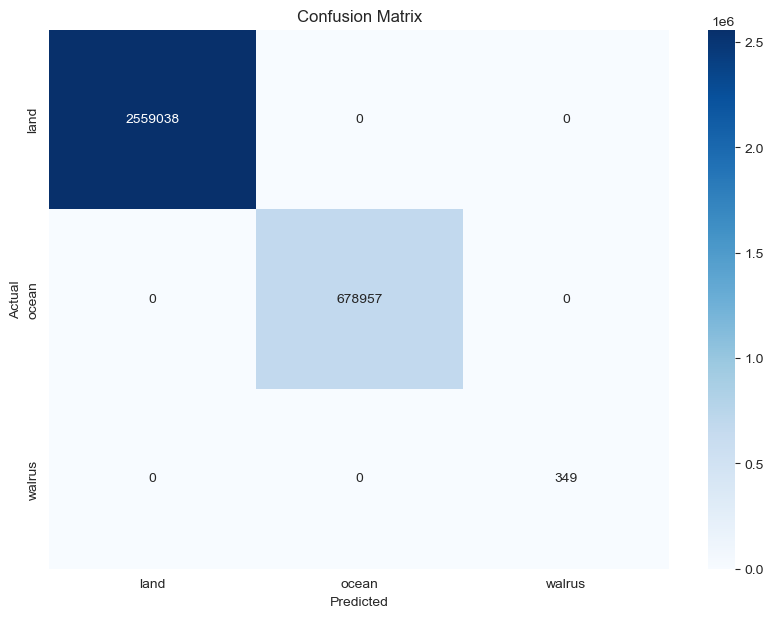

In [20]:
# Evaluate the models on the test set
test_image_paths = [image_path for image_path, _ in file_pairs.items() if image_path in unlabeled_image_paths]


def extract_true_labels(image_path, walrus_shapefile):
    # Read the image
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform
        height, width = src.height, src.width

    # Read the walrus shapefile
    gdf = gpd.read_file(walrus_shapefile)

    # Create a mask for walrus areas
    walrus_mask = geometry_mask(gdf.geometry, transform=transform, invert=True, out_shape=(height, width))

    # Create a label array
    labels = np.full((height, width), combined_le.transform(['land'])[0], dtype=np.int32)

    # Set walrus areas in the label array
    labels[walrus_mask] = combined_le.transform(['walrus'])[0]

    # Identify ocean areas (assuming pixels with all zeros are ocean)
    ocean_mask = np.all(image == 0, axis=0)
    labels[ocean_mask] = combined_le.transform(['ocean'])[0]

    return labels.flatten()


def evaluate_model(validation_pairs, ocean_model, walrus_model):
    y_true = []
    y_pred = []

    for image_path, walrus_shapefile in validation_pairs.items():
        predicted = predict_image(image_path, ocean_model, walrus_model)
        if predicted.size != 0:
            if walrus_shapefile:
                true_labels = extract_true_labels(image_path, walrus_shapefile)
                y_true.extend(true_labels)
                y_pred.extend(predicted.flatten())
                print(f"Valid prediction for {image_path}: shape {predicted.shape}")
            else:
                print(f"No walrus shapefile for {image_path}, using predicted labels")
                # For images without walrus shapefiles, we'll use the predicted labels
                # This assumes that if there's no walrus shapefile, there are no walrus in the image
                y_true.extend(predicted.flatten())
                y_pred.extend(predicted.flatten())
        else:
            print(f"No valid prediction for {image_path}")

    if len(y_true) == 0 or len(y_pred) == 0:
        raise ValueError("No valid predictions made. Check the models and input data.")

    return np.array(y_true), np.array(y_pred)


# Run the evaluation function
try:
    y_true, y_pred_combined = evaluate_model(validation_pairs, binary_model, walrus_model)

    # Calculate Evaluation Metrics
    accuracy = accuracy_score(y_true, y_pred_combined)
    precision = precision_score(y_true, y_pred_combined, average='weighted')
    recall = recall_score(y_true, y_pred_combined, average='weighted')
    f1 = f1_score(y_true, y_pred_combined, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred_combined)

    # Print Metrics
    print("Combined Model (Post-Processed)")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Cohen's Kappa: {kappa}")

    print("\nClassification Report for Combined Model (Post-Processed):")
    print(classification_report(y_true, y_pred_combined, target_names=combined_le.classes_))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_combined)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=combined_le.classes_,
                yticklabels=combined_le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

except ValueError as e:
    print(e)


Labels present in buch_20230714_image.tif: ['land', 'ocean']


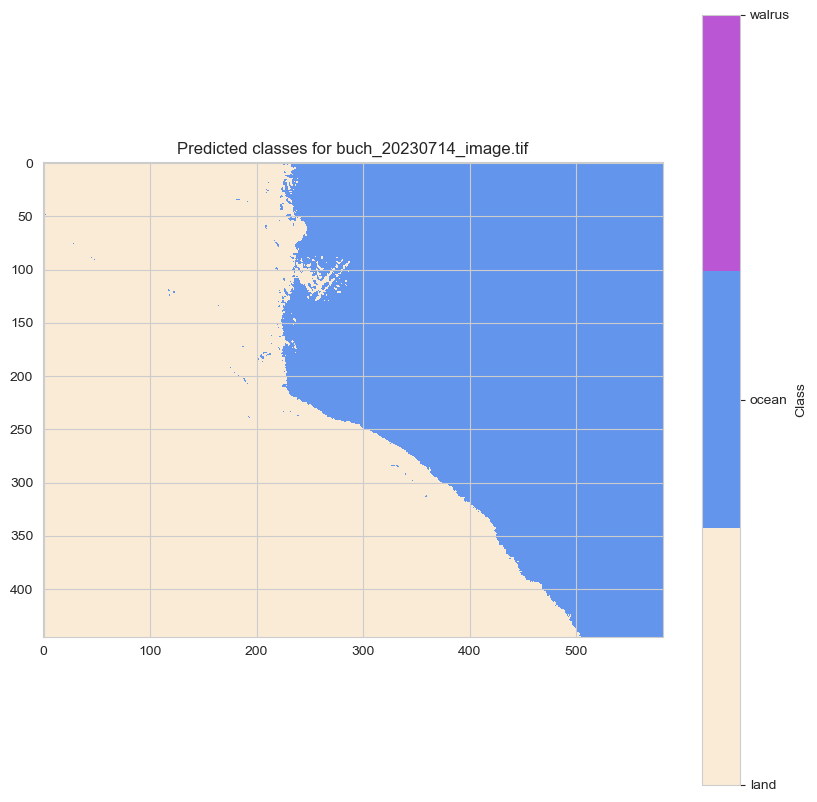

Labels present in buch_20230720_image.tif: ['land', 'ocean']


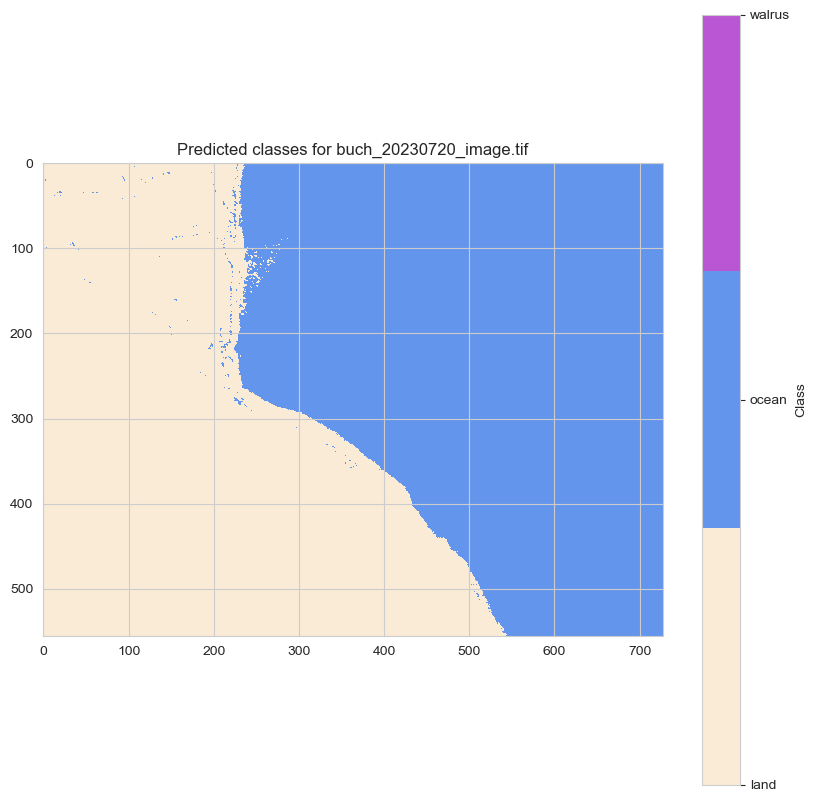

Labels present in buch_20230731_image.tif: ['land', 'ocean']


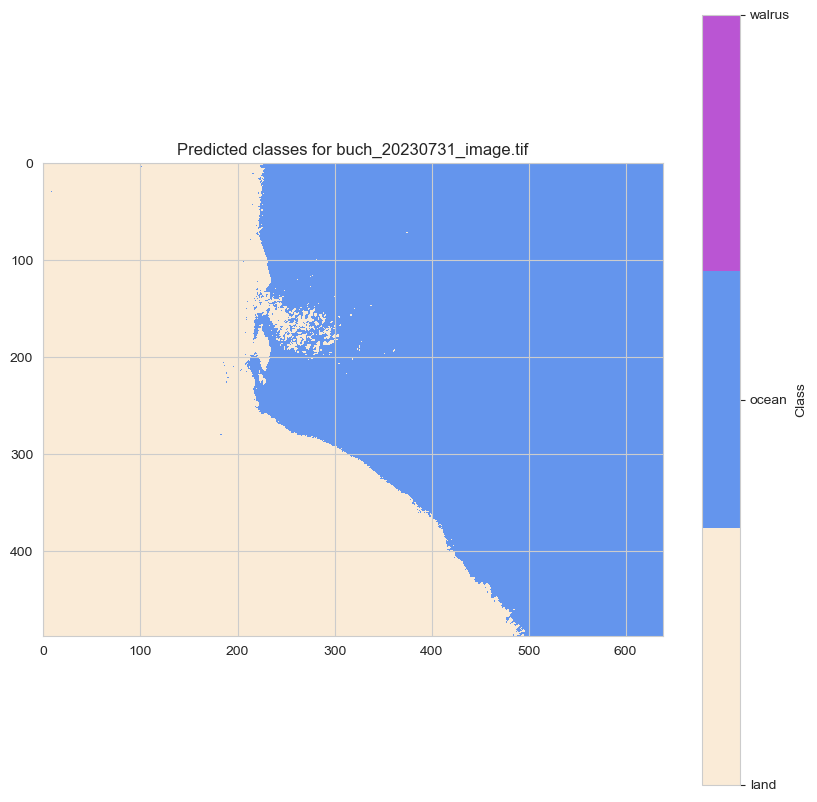

Labels present in buch_20230923_image.tif: ['land', 'ocean']


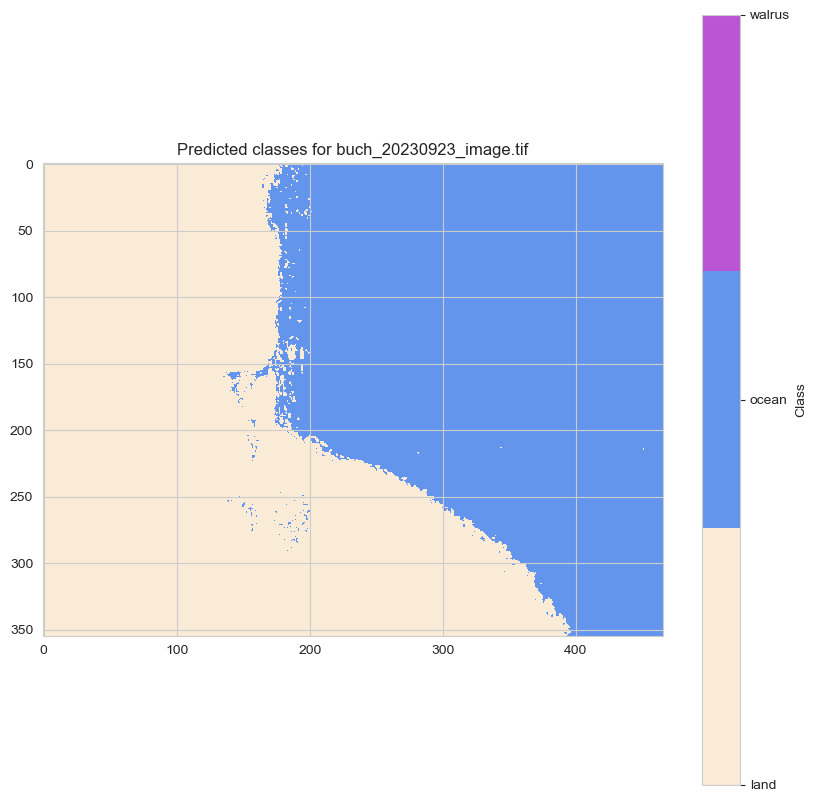

Labels present in moff_20230717_image.tif: ['land', 'ocean']


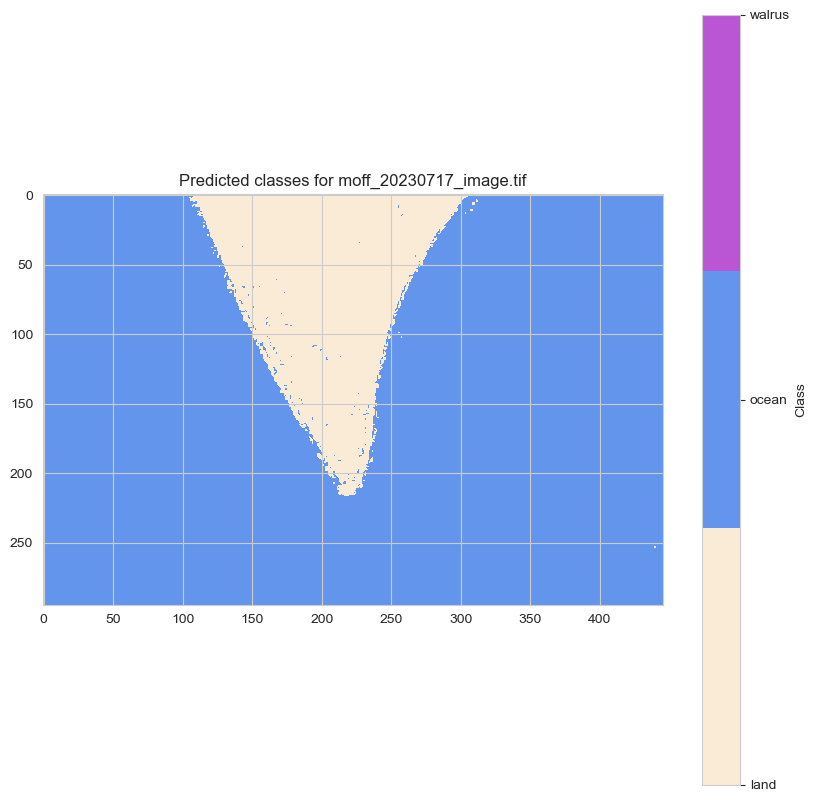

Labels present in pal_20230714_image.tif: ['land', 'ocean', 'walrus']


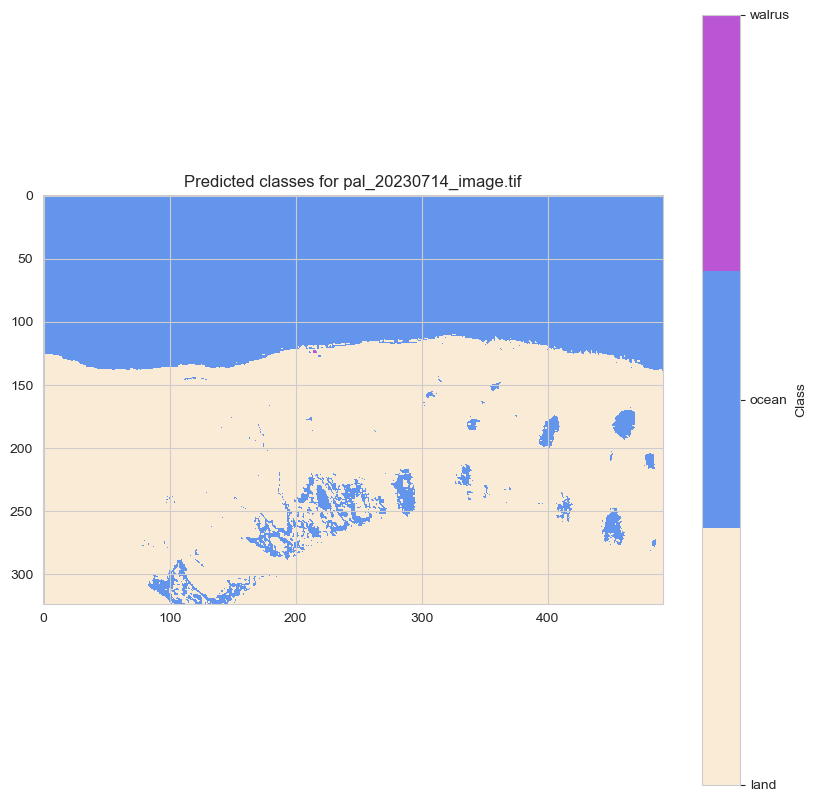

Labels present in pal_20230720_image.tif: ['land', 'ocean', 'walrus']


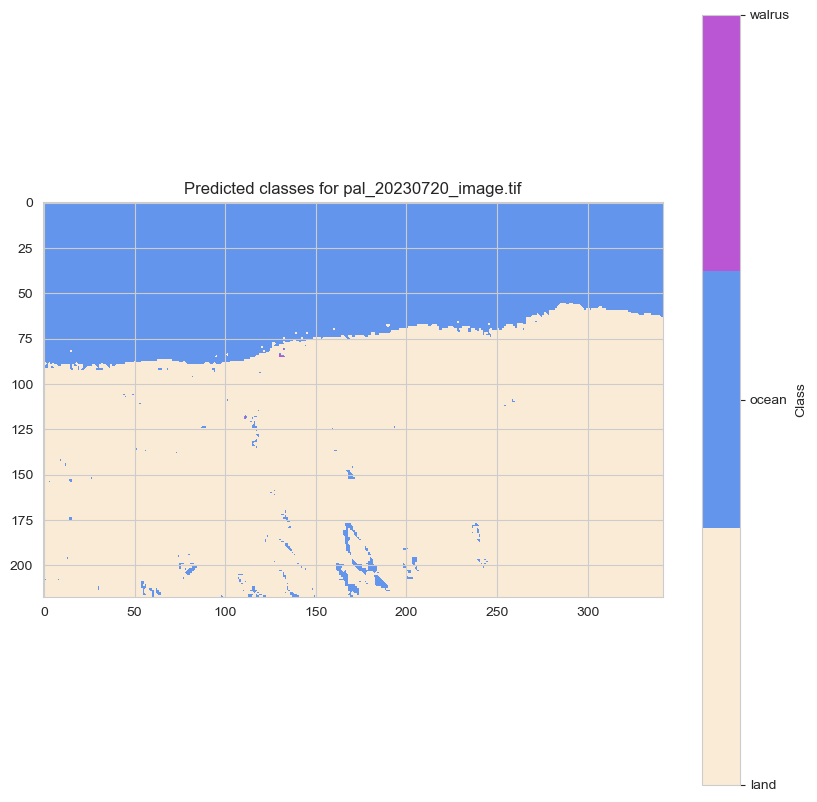

Labels present in pal_20230726_image.tif: ['land', 'ocean', 'walrus']


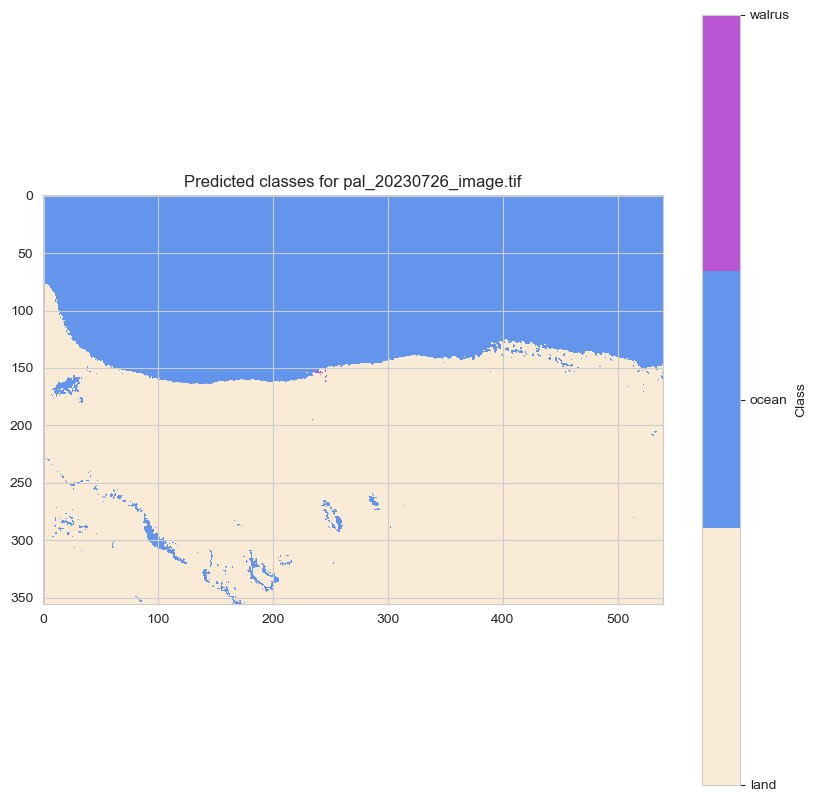

Labels present in sars_20230714_image.tif: ['land', 'ocean', 'walrus']


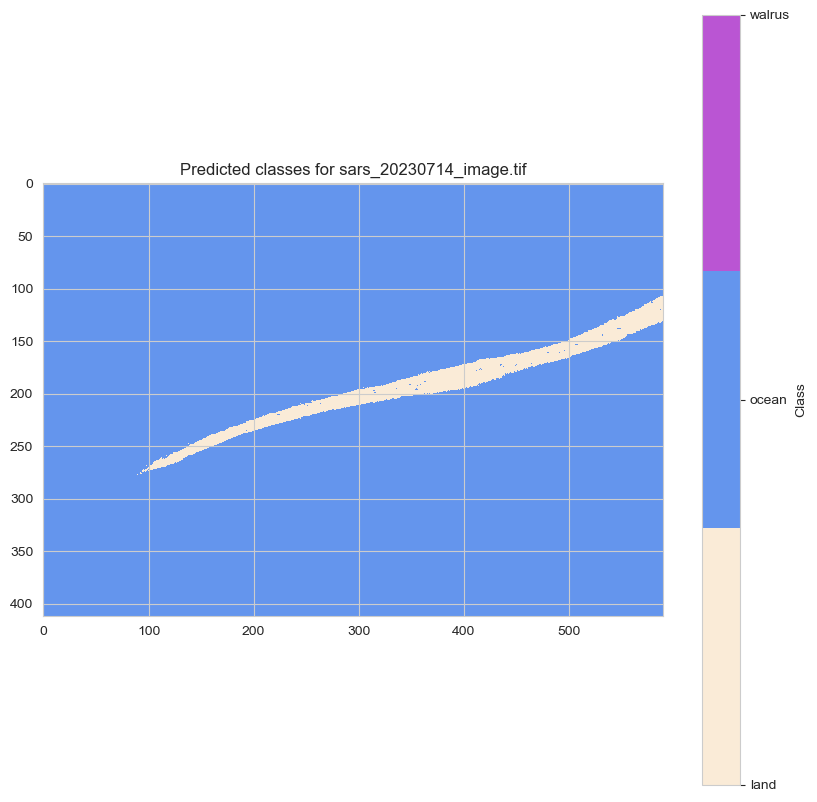

Labels present in sars_20230803_image.tif: ['land', 'ocean', 'walrus']


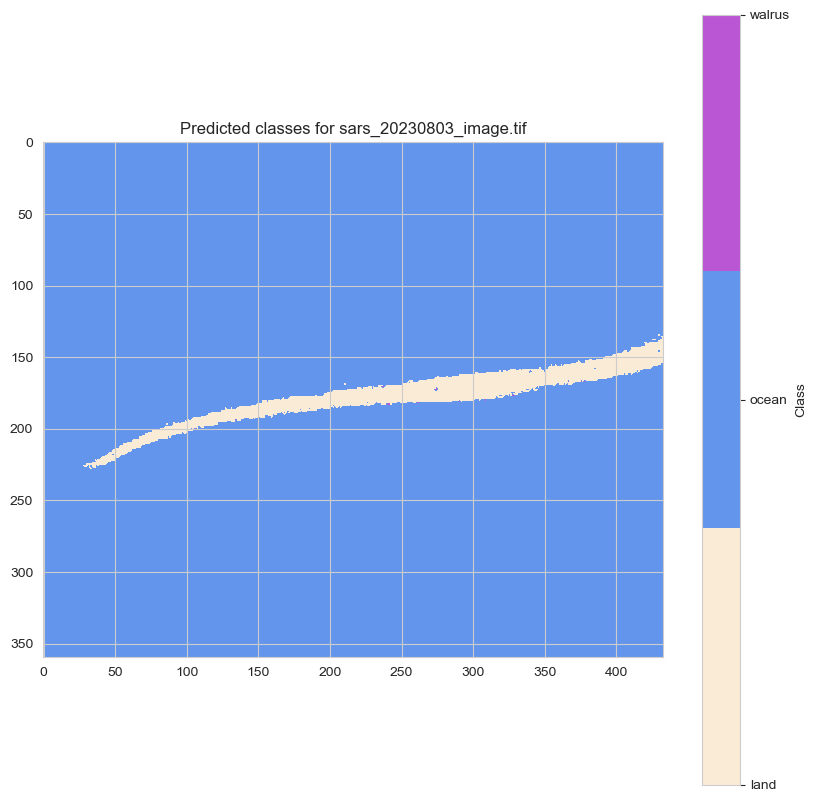

Labels present in tor_20230801_image.tif: ['land', 'ocean', 'walrus']


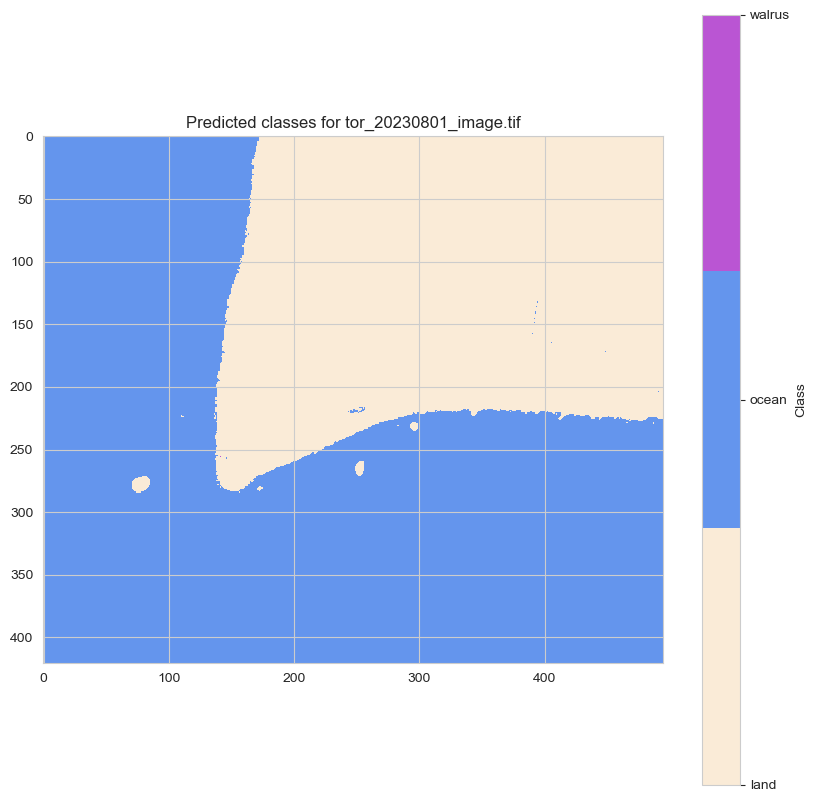

Labels present in tor_20230824_image.tif: ['land', 'ocean', 'walrus']


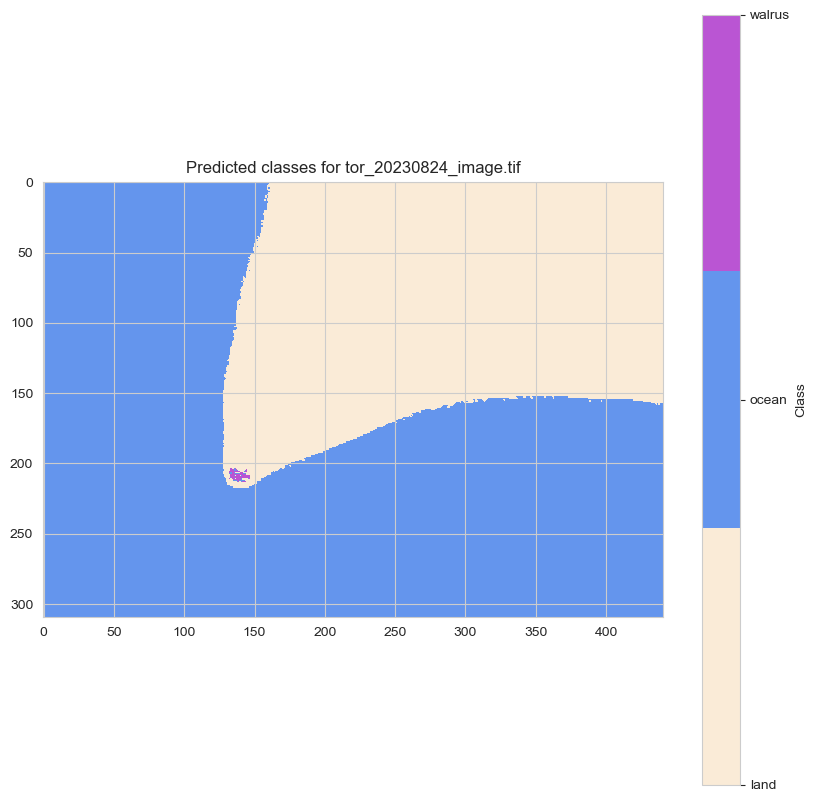

Labels present in tor_20230901_image.tif: ['land', 'ocean', 'walrus']


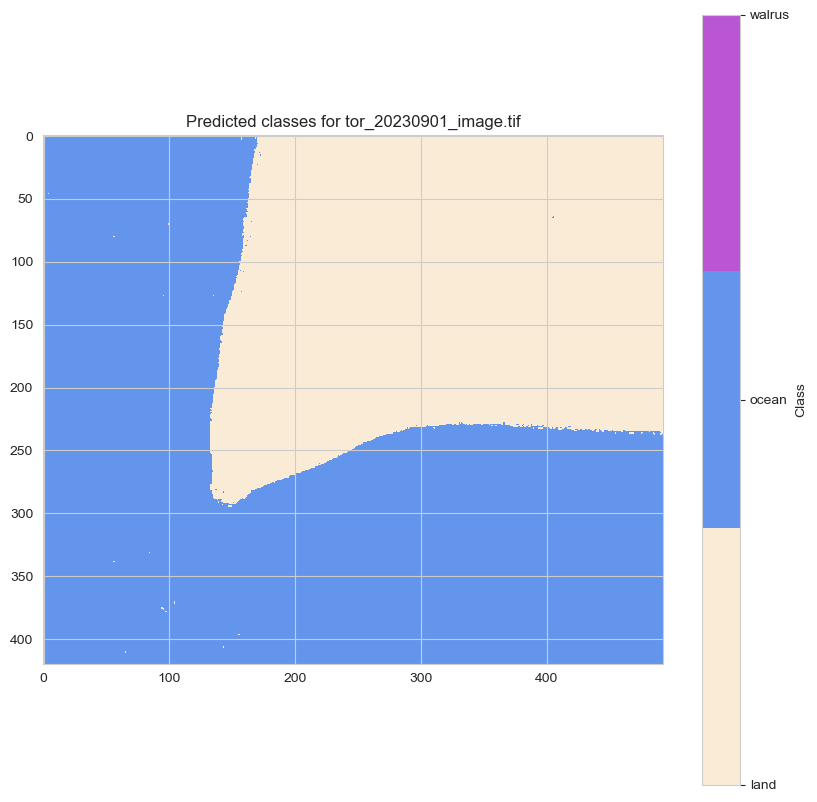

Labels present in tor_20230902_image.tif: ['land', 'ocean', 'walrus']


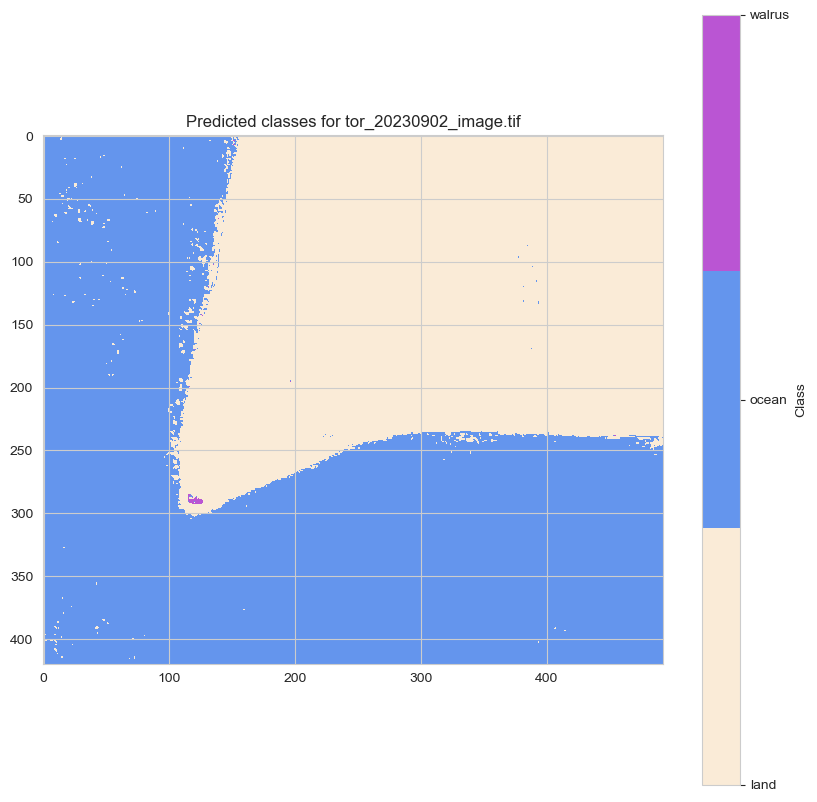

In [21]:
# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}

# Create a fixed color map based on combined labels
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])


# Function to predict classes for a given image using both models
def predict_image_combined(image_path, binary_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_ocean = image[3:].reshape((5, -1)).T  # Last 5 bands for binary model
        image_walrus = image[:5].reshape((5, -1)).T  # First 5 bands for walrus model

        # Predict ocean vs. not ocean
        ocean_predictions = binary_model.predict(image_ocean)

        # Predict walrus vs. land for non-ocean pixels
        land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]
        walrus_predictions = np.zeros_like(ocean_predictions)
        walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])

        # Combine predictions
        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)

        return combined_predictions.reshape((src.height, src.width))


# Predict classes for images with attached shapefiles
predicted_images = {}
for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
    predicted_images[image_path] = predict_image_combined(image_path, binary_model, walrus_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_) - 1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])

    # Highlight the labels present in the current image
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()


In [ ]:
# Load the binary model
binary_model_filename = "binary_ocean_not_ocean_model.joblib"
binary_model = joblib.load(binary_model_filename)
print("Binary model loaded successfully")

# Load the walrus model
walrus_model_filename = "walrus_vs_land_model.joblib"
walrus_model = joblib.load(walrus_model_filename)
print("Walrus model loaded successfully")


def predict_image_combined(image_path, binary_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        height, width = image.shape[1], image.shape[2]

        # Reshape the image data correctly
        image_ocean = image[3:].reshape(5, -1).T
        image_walrus = image[:5].reshape(5, -1).T

        # Predict ocean vs. not ocean
        ocean_predictions = binary_model.predict(image_ocean)

        # Predict walrus vs. land for non-ocean pixels
        land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]
        walrus_predictions = np.zeros_like(ocean_predictions)
        walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])

        # Combine predictions
        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)

        return combined_predictions.reshape((height, width))


# Predict classes for images
predicted_images = {}
for image_path in file_pairs.keys():
    predicted_images[image_path] = predict_image_combined(image_path, binary_model, walrus_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_) - 1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])

    # Highlight the labels present in the current image
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

In [32]:
import glob
import os
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from scipy.ndimage import label, binary_dilation
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, \
    classification_report, confusion_matrix
import seaborn as sns
import joblib
import rasterio
import geopandas as gpd
from rasterio.features import geometry_mas
from scipy.ndimage import binary_dilation, binary_erosion, label, generate_binary_structure
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.ndimage import binary_dilation, binary_erosion, label, generate_binary_structure

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")


# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None


all_image_paths = image_paths + unlabeled_image_paths


def pair_training_files(image_paths, shapefile_paths):
    training_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if matching_shapefiles:
            training_pairs[image_path] = matching_shapefiles[0]

    return training_pairs


def pair_validation_files(unlabeled_image_paths, walrus_paths):
    validation_pairs = {}
    for image_path in unlabeled_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        if matching_walrus:
            validation_pairs[image_path] = matching_walrus[0]
        else:
            validation_pairs[image_path] = None  # Include images without walrus shapefiles

    return validation_pairs


training_pairs = pair_training_files(image_paths, shapefile_paths)
validation_pairs = pair_validation_files(unlabeled_image_paths, new_walrus_paths)


def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    features, labels, img_name = np.array(features), np.array(labels), np.array(img_name)

    # Debugging print statements
    print(f"Extracted {features.shape[0]} features, {labels.shape[0]} labels from {image_path}")

    return features, labels, img_name


def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile, None)
        if img_features.size > 0:
            features.append(img_features)
            labels.append(img_labels)
            image_name.append(img_name)

    if features and labels:
        features = np.vstack(features)
        labels = np.hstack(labels)
        image_name = np.hstack(image_name)
    else:
        features = np.array(features)
        labels = np.array(labels)
        image_name = np.array(image_name)

    print(f"Total features: {features.shape}, Total labels: {labels.shape}, Total image names: {image_name.shape}")

    return features, labels, image_name


features, labels, image_name = get_dataset(training_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

ImportError: cannot import name 'geometry_mas' from 'rasterio.features' (C:\Users\Student\Documents\walrus_code\.venv\lib\site-packages\rasterio\features.py)

In [33]:
# Combine classes
dataset['combined_labels'] = dataset['labels'].apply(lambda x: 'land' if x in ['rock', 'ice', 'freshwater'] else (
    'walrus' if x in ['walrus_pure', 'walrus_mixed'] else x))
combined_le = LabelEncoder()
dataset['combined_encoded_labels'] = combined_le.fit_transform(dataset['combined_labels'])


def custom_train_test_split(df, label_col='combined_encoded_labels', test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1 / test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df[label_col]):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]

        # Ensure that rare classes are in the training set
        if not all(cls in train_df[label_col].values for cls in [combined_le.transform(['walrus'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in
               unique_islands):
            print(f"Train set size: {train_df.shape}, Test set size: {test_df.shape}")
            return train_df, test_df
    return None, None


train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')

# Split the data
train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')
X_train, y_train = train_df.drop(
    columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, train_df[
    'combined_encoded_labels'].values
X_test, y_test = test_df.drop(
    columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, test_df[
    'combined_encoded_labels'].values

Train set size: (970828, 13), Test set size: (242707, 13)
Train set size: (970828, 13), Test set size: (242707, 13)


In [35]:
# Separate features for ocean vs. not ocean and land vs. walrus
X_train_ocean = X_train[:, 3:]  # Last 5 bands for ocean vs. not ocean
X_test_ocean = X_test[:, 3:]
X_train_walrus = X_train[:, :5]  # First 5 bands for land vs. walrus
X_test_walrus = X_test[:, :5]

# Train the binary classifier (ocean vs. not ocean)
binary_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

binary_model.fit(X_train_ocean, y_train)

# Debugging print statements
print(f"Binary model trained on {X_train_ocean.shape} features")

# Save the binary model
binary_model_filename = "binary_ocean_not_ocean_model5.joblib"
joblib.dump(binary_model, binary_model_filename)

Binary model trained on (970828, 5) features


['binary_ocean_not_ocean_model5.joblib']

In [36]:
# Filter land and walrus pixels for training
not_ocean_mask = train_df['combined_labels'] == 'land'
X_train_not_ocean = X_train_walrus[not_ocean_mask]
y_train_not_ocean = train_df.loc[not_ocean_mask, 'encoded_labels'].values

# Train the walrus classifier (land vs. walrus)
walrus_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

non_ocean_mask_train = y_train != combined_le.transform(['ocean'])[0]
walrus_model.fit(X_train_walrus[non_ocean_mask_train], y_train[non_ocean_mask_train])

# Debugging print statements
print(f"Walrus model trained on {X_train_walrus[non_ocean_mask_train].shape} features")

# Save the walrus model
walrus_model_filename = "walrus_vs_land_model5.joblib"
joblib.dump(walrus_model, walrus_model_filename)

Walrus model trained on (347398, 5) features


['walrus_vs_land_model5.joblib']

In [37]:
# Function to remove small isolated pixels for specific target labels only
def connected_component_analysis(prediction, min_size=50, target_labels=[]):
    cleaned_prediction = np.copy(prediction)
    for target_label in target_labels:
        mask = prediction == target_label
        labeled_array, num_features = label(mask)
        sizes = np.bincount(labeled_array.ravel())
        mask_sizes = sizes >= min_size
        mask_sizes[0] = 0  # Ensure background is not considered
        cleaned_mask = mask_sizes[labeled_array]
        cleaned_prediction[mask & ~cleaned_mask] = 0  # Set the speckles to background (0)
    return cleaned_prediction

# Function to remove speckles using morphological operations for specific target labels only
def remove_speckles(prediction, structure_size=3, target_labels=[]):
    cleaned_prediction = np.copy(prediction)
    for target_label in target_labels:
        mask = prediction == target_label
        structure = generate_binary_structure(2, 1)
        eroded = binary_erosion(mask, structure=structure, iterations=structure_size)
        cleaned = binary_dilation(eroded, structure=structure, iterations=structure_size)
        cleaned_prediction[mask & ~cleaned] = 0  # Set the speckles to background (0)
    return cleaned_prediction


def proximity_filter(prediction, ocean_mask, radius=50):
    structure = np.ones((radius, radius), dtype=bool)
    if ocean_mask.ndim == 2:
        dilated_ocean = binary_dilation(ocean_mask, structure=structure)
    else:
        raise ValueError("ocean_mask must be a 2D array")

    walrus_mask = prediction == combined_le.transform(['walrus'])[0]
    walrus_mask[~dilated_ocean] = False
    prediction[walrus_mask] = combined_le.transform(['walrus'])[0]
    prediction[(prediction == combined_le.transform(['walrus'])[0]) & (~walrus_mask)] = combined_le.transform(['land'])[
        0]
    return prediction


# Main post-processing function
def post_process_prediction(prediction, original_shape, min_size=50):
    if prediction.size != original_shape[0] * original_shape[1]:
        raise ValueError(f"Prediction size {prediction.size} does not match the original shape {original_shape[0] * original_shape[1]}")

    prediction = prediction.reshape(original_shape)
    
    ocean_label = combined_le.transform(['ocean'])[0]
    land_label = combined_le.transform(['land'])[0]
    
    # Clean up speckles and small isolated pixels for ocean and land only
    prediction = remove_speckles(prediction, structure_size=2, target_labels=[ocean_label, land_label])
    prediction = connected_component_analysis(prediction, min_size=min_size, target_labels=[ocean_label, land_label])
    
    return prediction

# Function to predict classes for a given image using both models
def predict_image(image_path, ocean_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        original_shape = (src.height, src.width)
        num_pixels = src.height * src.width

        # Ensure correct reshaping for ocean model
        image_ocean = image[3:].reshape((image.shape[1] * image.shape[2], -1))
        image_walrus = image[:5].reshape((image.shape[1] * image.shape[2], -1))

        # Make predictions
        try:
            ocean_predictions = ocean_model.predict(image_ocean)
        except Exception as e:
            print(f"Error in ocean predictions for {image_path}: {e}")
            return np.array([])  # Return empty array if prediction fails

        try:
            land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]
            walrus_predictions = np.zeros_like(ocean_predictions)
            walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])
        except Exception as e:
            print(f"Error in walrus predictions for {image_path}: {e}")
            return np.array([])  # Return empty array if prediction fails

        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)

        if combined_predictions.size != num_pixels:
            raise ValueError(f"Combined predictions size {combined_predictions.size} does not match the number of pixels {num_pixels}")

        combined_predictions = post_process_prediction(combined_predictions, original_shape)

        return combined_predictions

In [39]:
from scipy.ndimage import binary_dilation, binary_erosion, label, generate_binary_structure

Valid prediction for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\buch_20230825_image.tif: shape (180, 293)
Valid prediction for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\buch_20230901_image.tif: shape (180, 285)
No walrus shapefile for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\pal_20230817_image.tif, using predicted labels
No walrus shapefile for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\pal_20230901_image.tif, using predicted labels
No walrus shapefile for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\pal_20230902_image.tif, using predicted labels
No walrus shapefile for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\pal_20230910_image.tif, using predicted labels
No walrus shapefile for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\pal_20230923_image.tif, using predicted labels
No walrus shapefile for C:\Users\Student\Documents

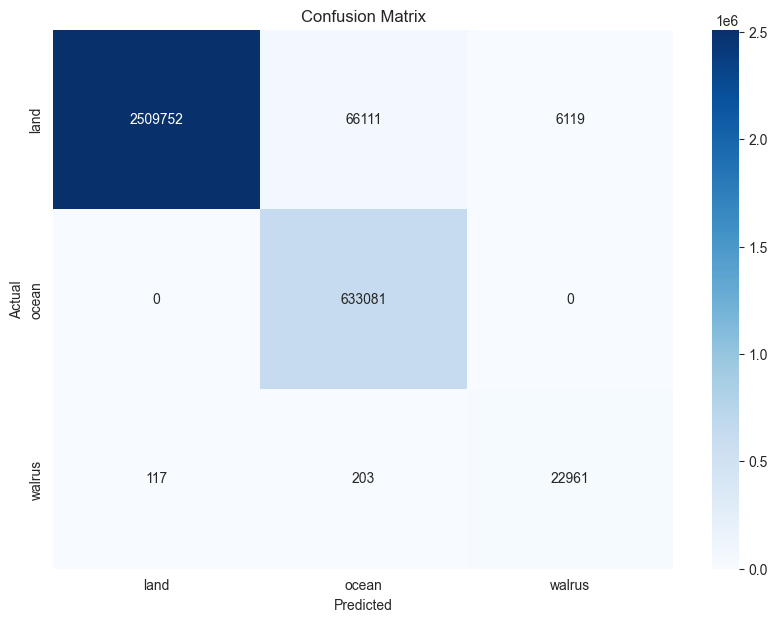

In [40]:
# Evaluate the models on the test set
test_image_paths = [image_path for image_path, _ in file_pairs.items() if image_path in unlabeled_image_paths]


def extract_true_labels(image_path, walrus_shapefile):
    # Read the image
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform
        height, width = src.height, src.width

    # Read the walrus shapefile
    gdf = gpd.read_file(walrus_shapefile)

    # Create a mask for walrus areas
    walrus_mask = geometry_mask(gdf.geometry, transform=transform, invert=True, out_shape=(height, width))

    # Create a label array
    labels = np.full((height, width), combined_le.transform(['land'])[0], dtype=np.int32)

    # Set walrus areas in the label array
    labels[walrus_mask] = combined_le.transform(['walrus'])[0]

    # Identify ocean areas (assuming pixels with all zeros are ocean)
    ocean_mask = np.all(image == 0, axis=0)
    labels[ocean_mask] = combined_le.transform(['ocean'])[0]

    return labels.flatten()


def evaluate_model(validation_pairs, ocean_model, walrus_model):
    y_true = []
    y_pred = []

    for image_path, walrus_shapefile in validation_pairs.items():
        predicted = predict_image(image_path, ocean_model, walrus_model)
        if predicted.size != 0:
            if walrus_shapefile:
                true_labels = extract_true_labels(image_path, walrus_shapefile)
                y_true.extend(true_labels)
                y_pred.extend(predicted.flatten())
                print(f"Valid prediction for {image_path}: shape {predicted.shape}")
            else:
                print(f"No walrus shapefile for {image_path}, using predicted labels")
                # For images without walrus shapefiles, we'll use the predicted labels
                # This assumes that if there's no walrus shapefile, there are no walrus in the image
                y_true.extend(predicted.flatten())
                y_pred.extend(predicted.flatten())
        else:
            print(f"No valid prediction for {image_path}")

    if len(y_true) == 0 or len(y_pred) == 0:
        raise ValueError("No valid predictions made. Check the models and input data.")

    return np.array(y_true), np.array(y_pred)


# Run the evaluation function
try:
    y_true, y_pred_combined = evaluate_model(validation_pairs, binary_model, walrus_model)

    # Calculate Evaluation Metrics
    accuracy = accuracy_score(y_true, y_pred_combined)
    precision = precision_score(y_true, y_pred_combined, average='weighted')
    recall = recall_score(y_true, y_pred_combined, average='weighted')
    f1 = f1_score(y_true, y_pred_combined, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred_combined)

    # Print Metrics
    print("Combined Model (Post-Processed)")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Cohen's Kappa: {kappa}")

    print("\nClassification Report for Combined Model (Post-Processed):")
    print(classification_report(y_true, y_pred_combined, target_names=combined_le.classes_))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_combined)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=combined_le.classes_,
                yticklabels=combined_le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

except ValueError as e:
    print(e)

Labels present in buch_20230714_image.tif: ['land', 'ocean', 'walrus']


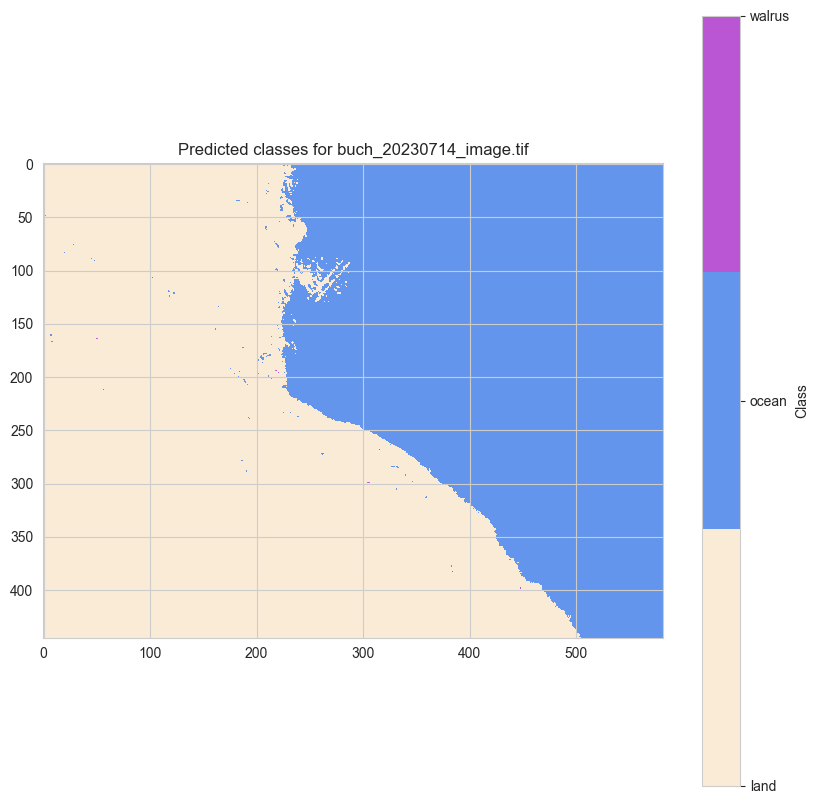

Labels present in buch_20230720_image.tif: ['land', 'ocean', 'walrus']


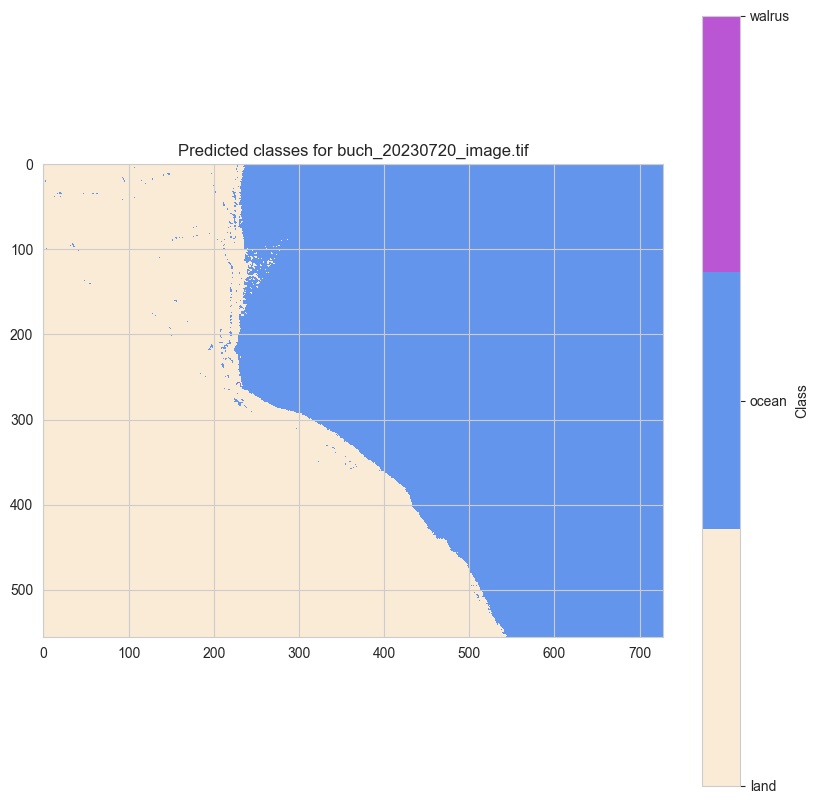

Labels present in buch_20230731_image.tif: ['land', 'ocean']


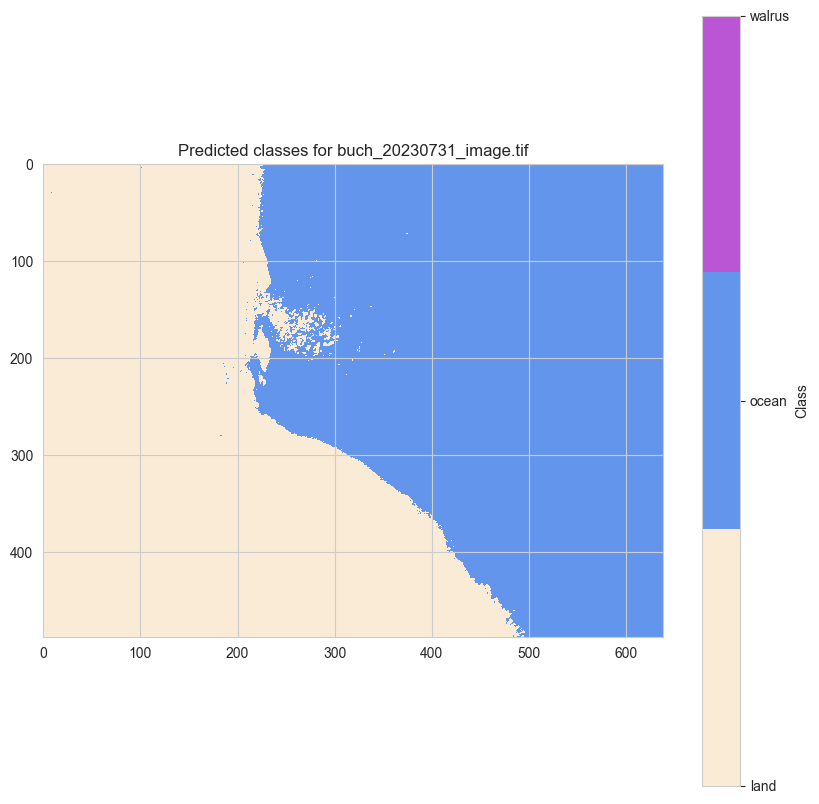

Labels present in buch_20230923_image.tif: ['land', 'ocean']


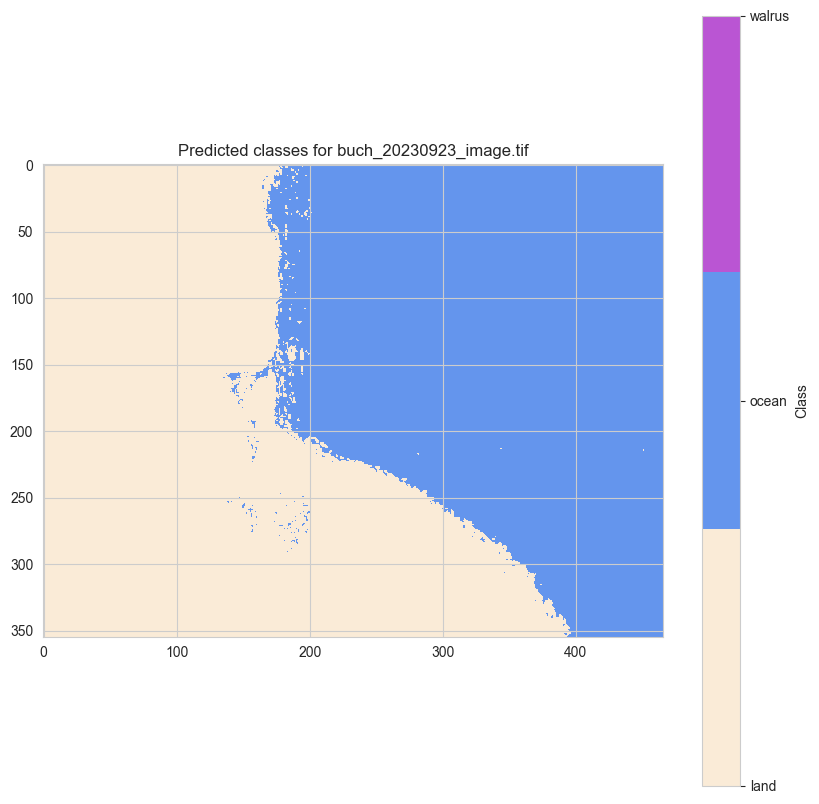

Labels present in moff_20230717_image.tif: ['land', 'ocean', 'walrus']


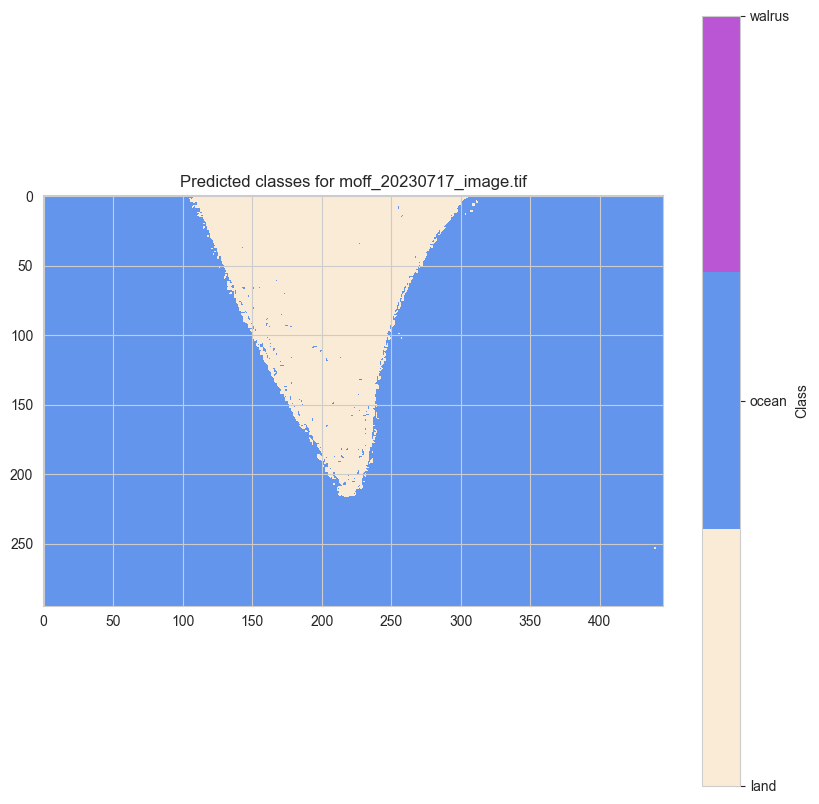

Labels present in pal_20230714_image.tif: ['land', 'ocean', 'walrus']


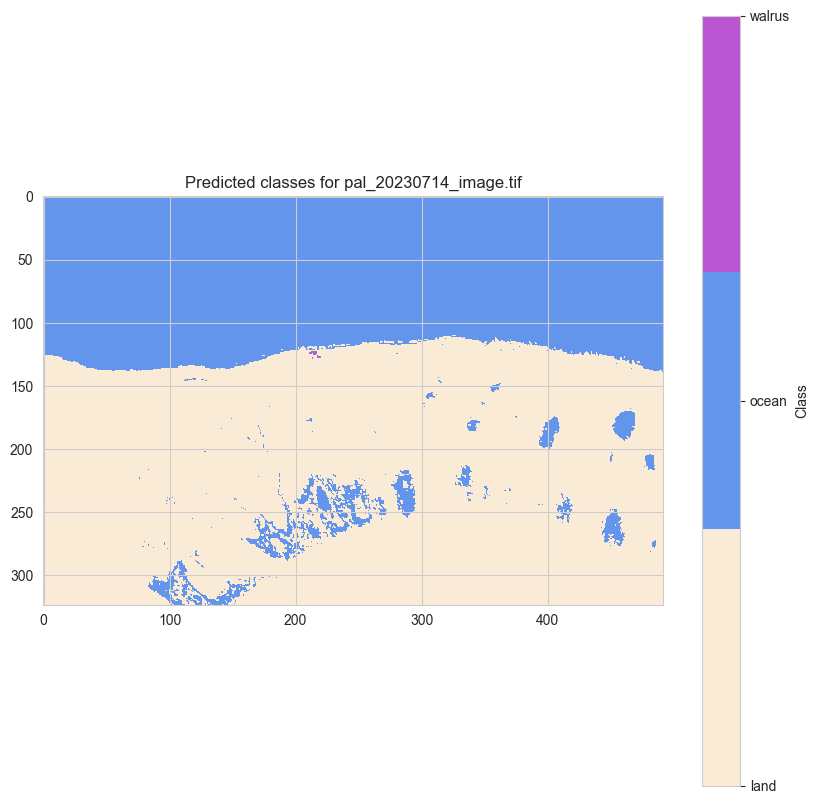

Labels present in pal_20230720_image.tif: ['land', 'ocean', 'walrus']


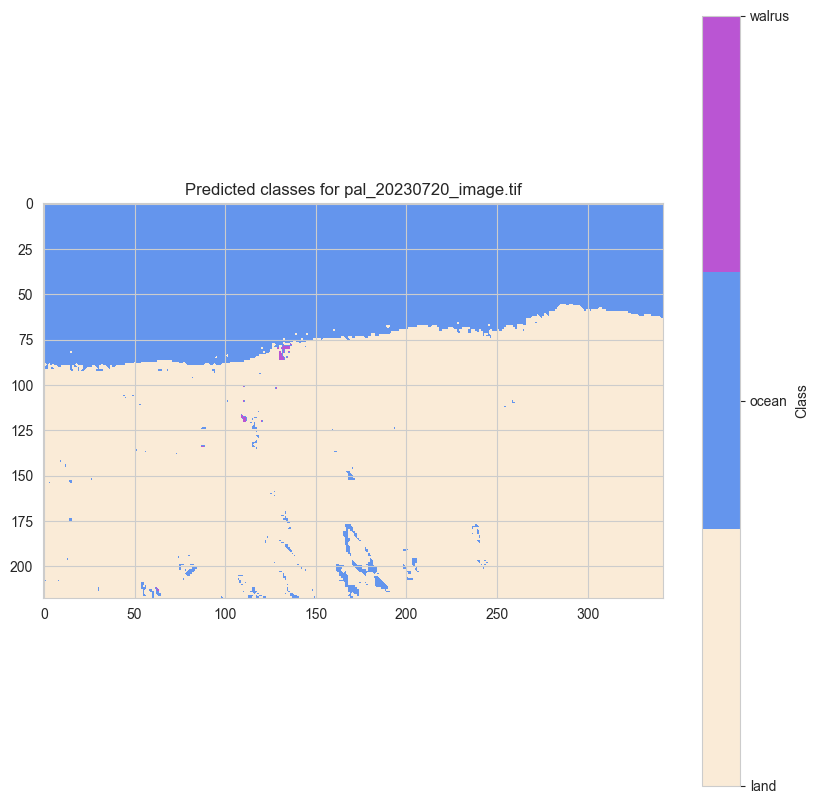

Labels present in pal_20230726_image.tif: ['land', 'ocean', 'walrus']


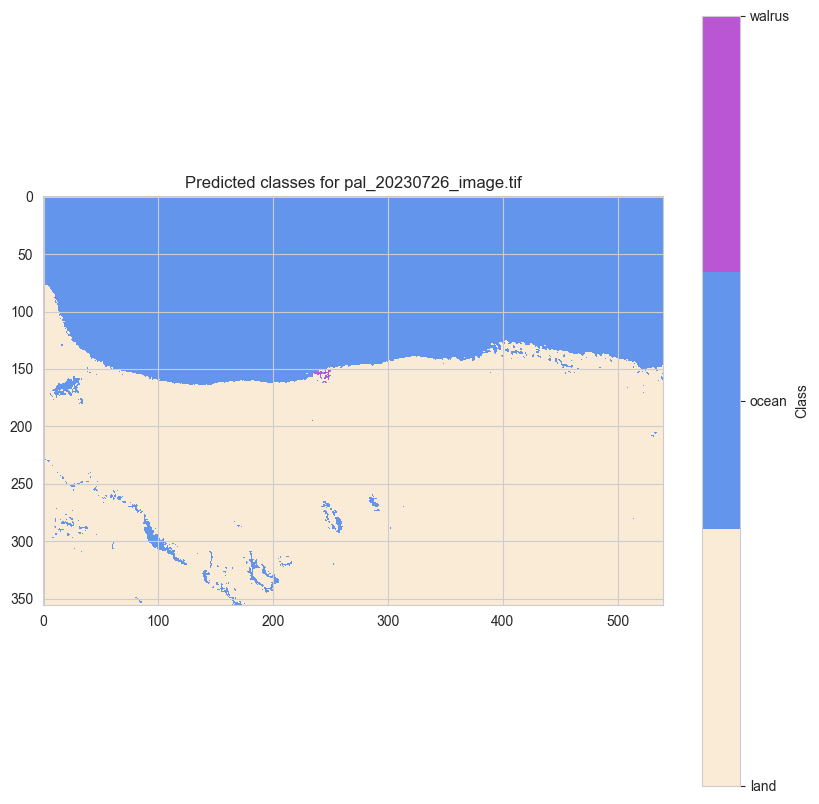

Labels present in sars_20230714_image.tif: ['land', 'ocean', 'walrus']


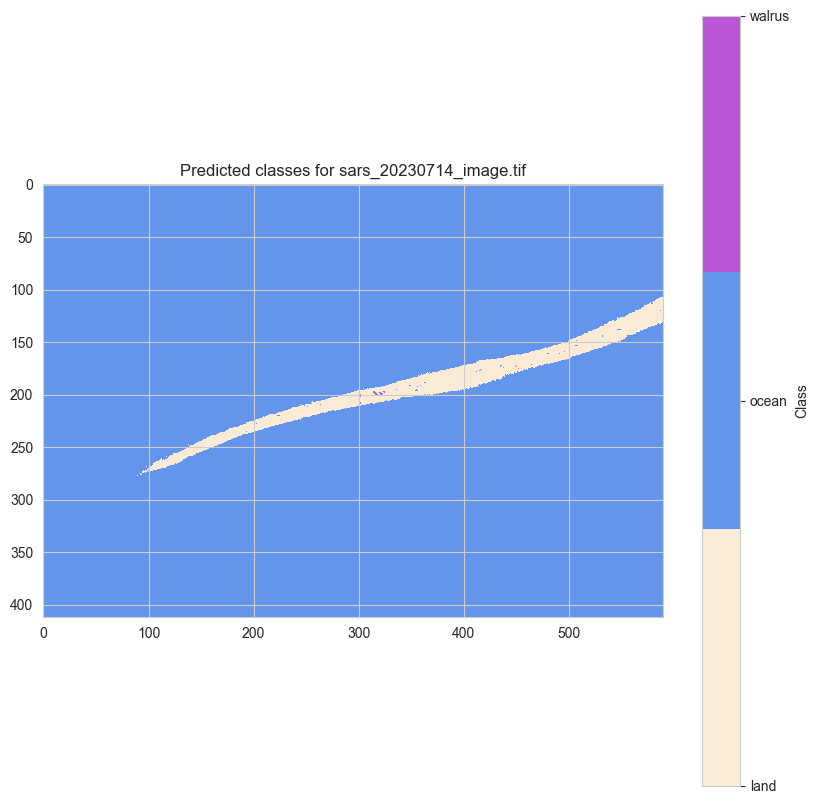

Labels present in sars_20230803_image.tif: ['land', 'ocean', 'walrus']


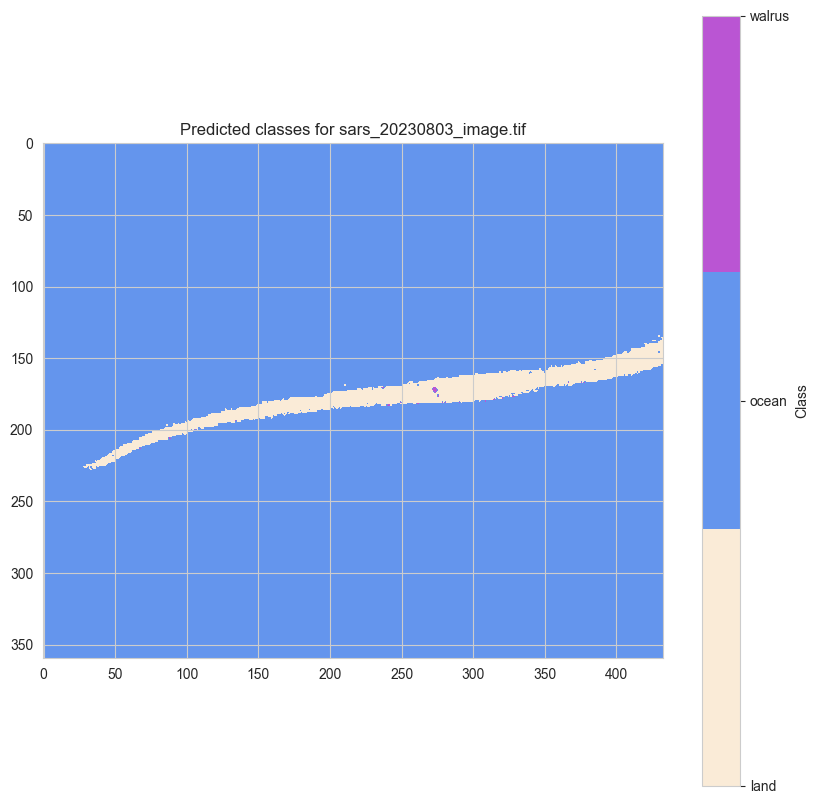

Labels present in tor_20230801_image.tif: ['land', 'ocean', 'walrus']


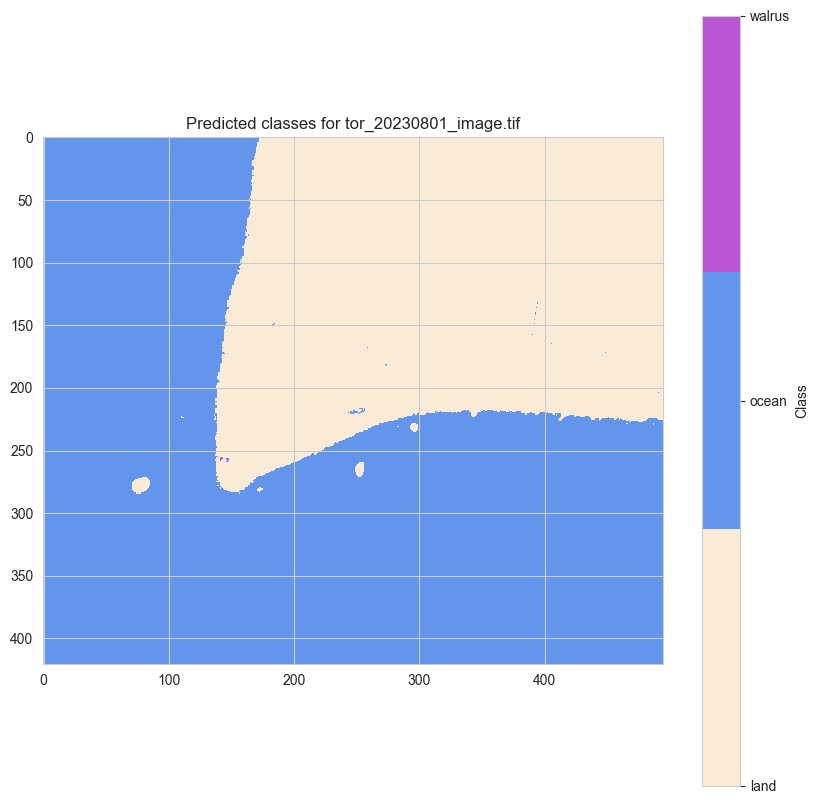

Labels present in tor_20230824_image.tif: ['land', 'ocean', 'walrus']


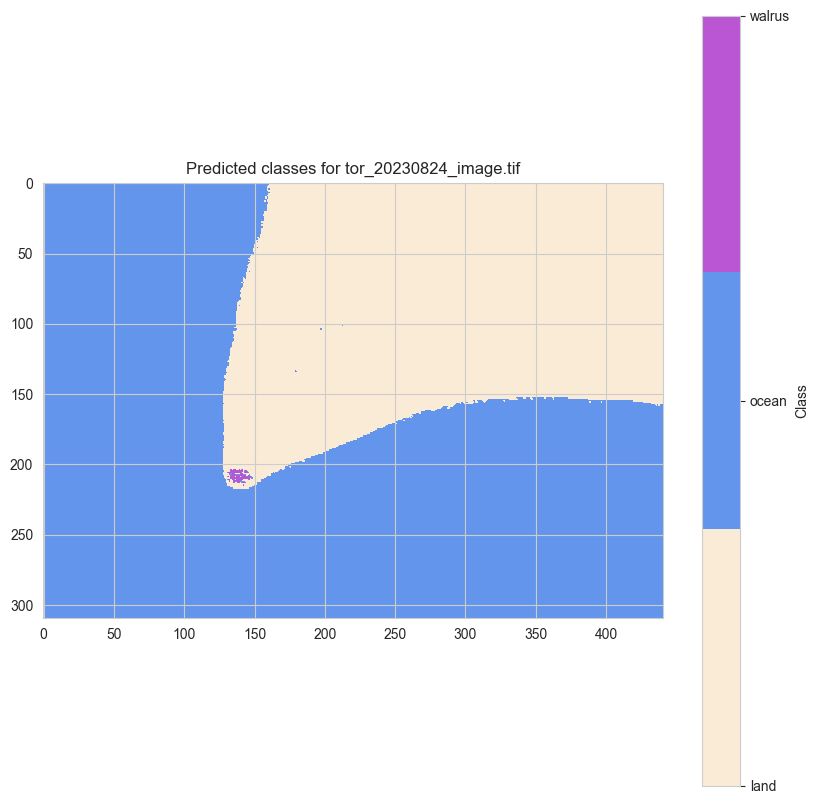

Labels present in tor_20230901_image.tif: ['land', 'ocean', 'walrus']


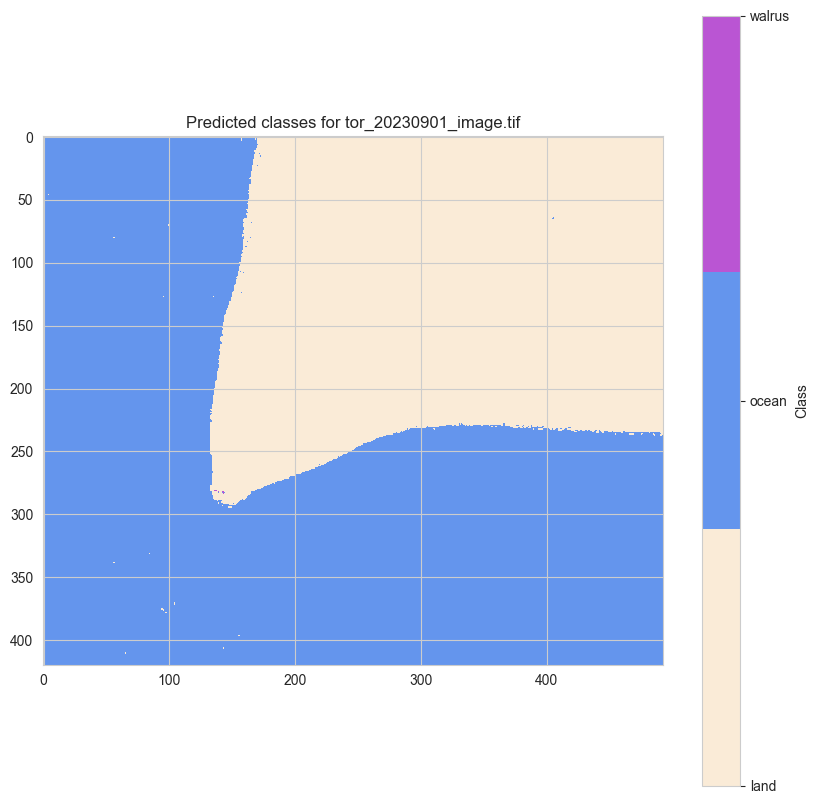

Labels present in tor_20230902_image.tif: ['land', 'ocean', 'walrus']


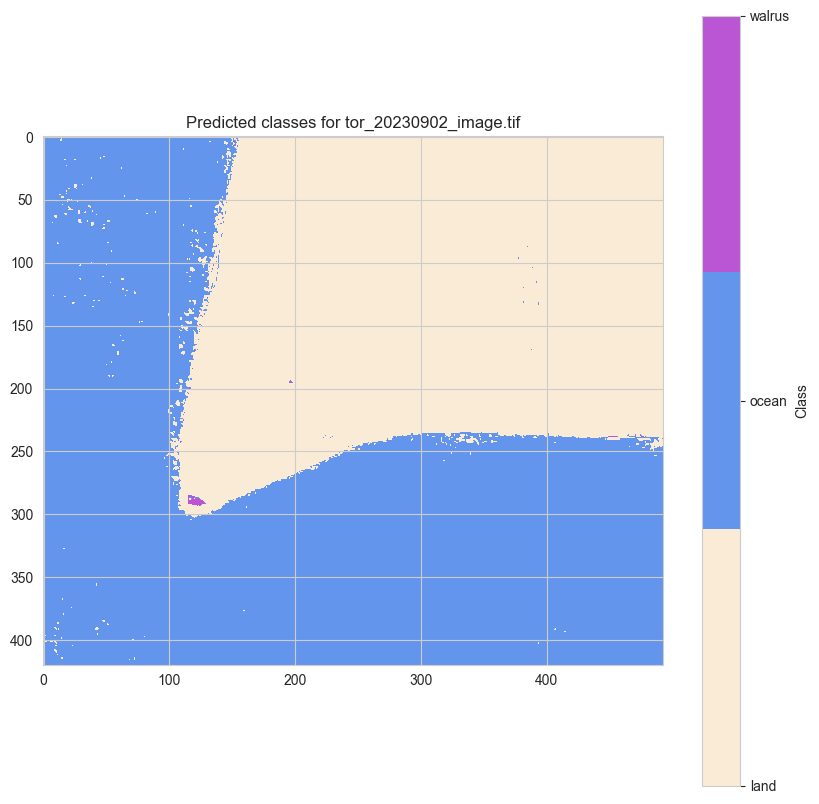

In [41]:
# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}

# Create a fixed color map based on combined labels
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])


# Function to predict classes for a given image using both models
def predict_image_combined(image_path, binary_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_ocean = image[3:].reshape((5, -1)).T  # Last 5 bands for binary model
        image_walrus = image[:5].reshape((5, -1)).T  # First 5 bands for walrus model

        # Predict ocean vs. not ocean
        ocean_predictions = binary_model.predict(image_ocean)

        # Predict walrus vs. land for non-ocean pixels
        land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]
        walrus_predictions = np.zeros_like(ocean_predictions)
        walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])

        # Combine predictions
        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)

        return combined_predictions.reshape((src.height, src.width))


# Predict classes for images with attached shapefiles
predicted_images = {}
for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
    predicted_images[image_path] = predict_image_combined(image_path, binary_model, walrus_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_) - 1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])

    # Highlight the labels present in the current image
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()


Binary model loaded successfully
Walrus model loaded successfully
Labels present in buch_20230714_image.tif: ['land', 'ocean', 'walrus']


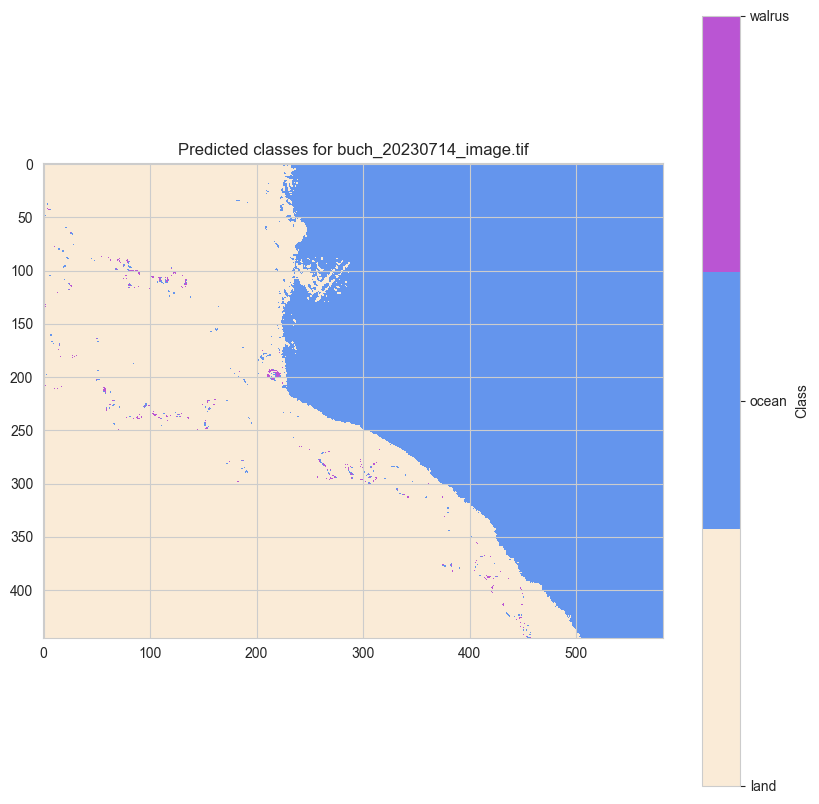

Labels present in buch_20230720_image.tif: ['land', 'ocean', 'walrus']


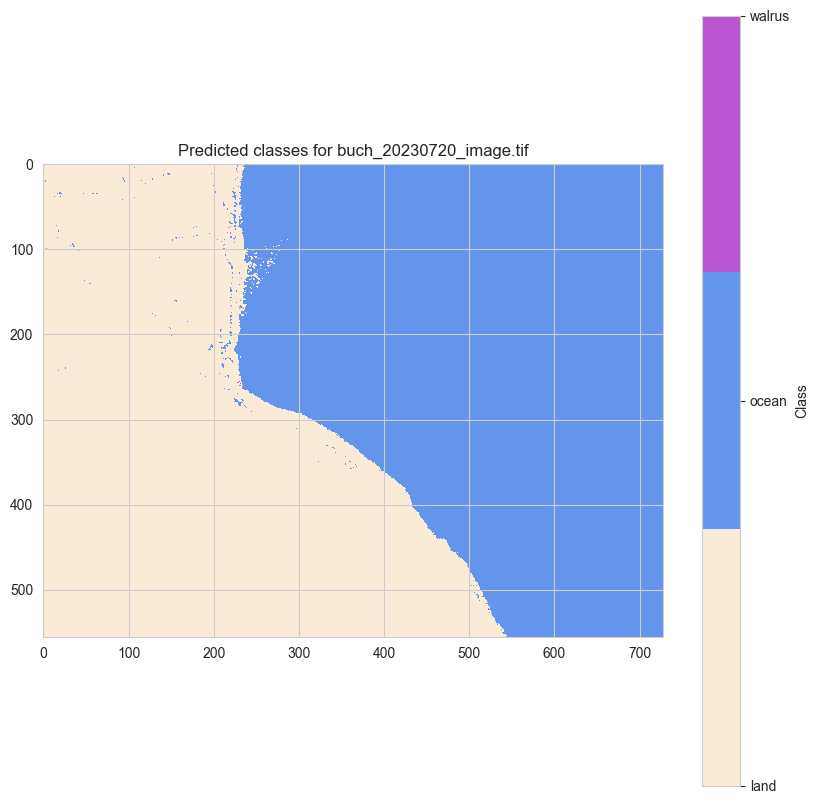

Labels present in buch_20230731_image.tif: ['land', 'ocean', 'walrus']


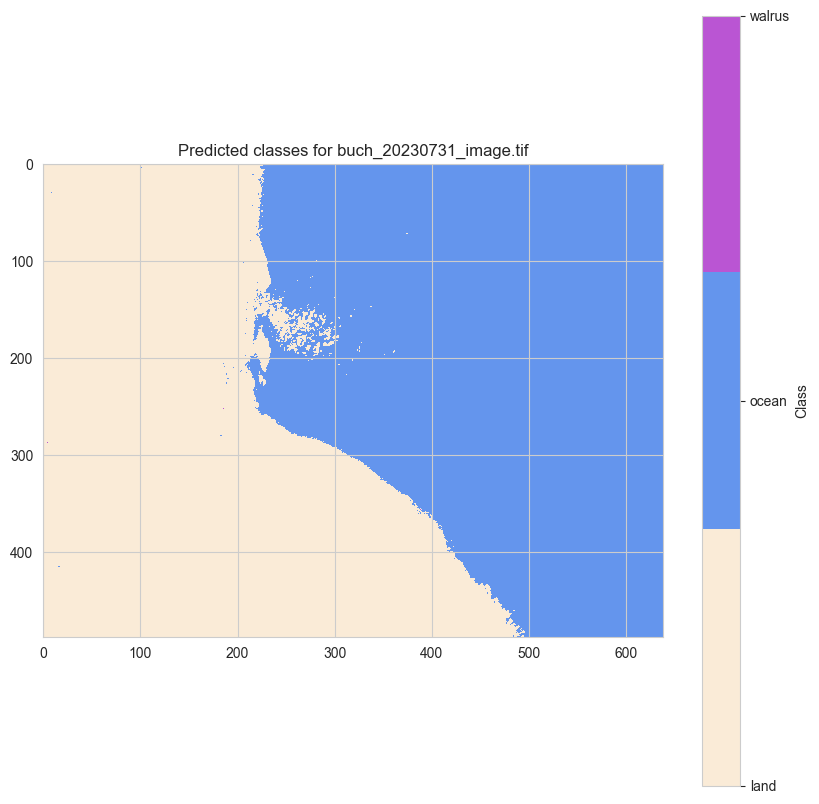

Labels present in buch_20230923_image.tif: ['land', 'ocean']


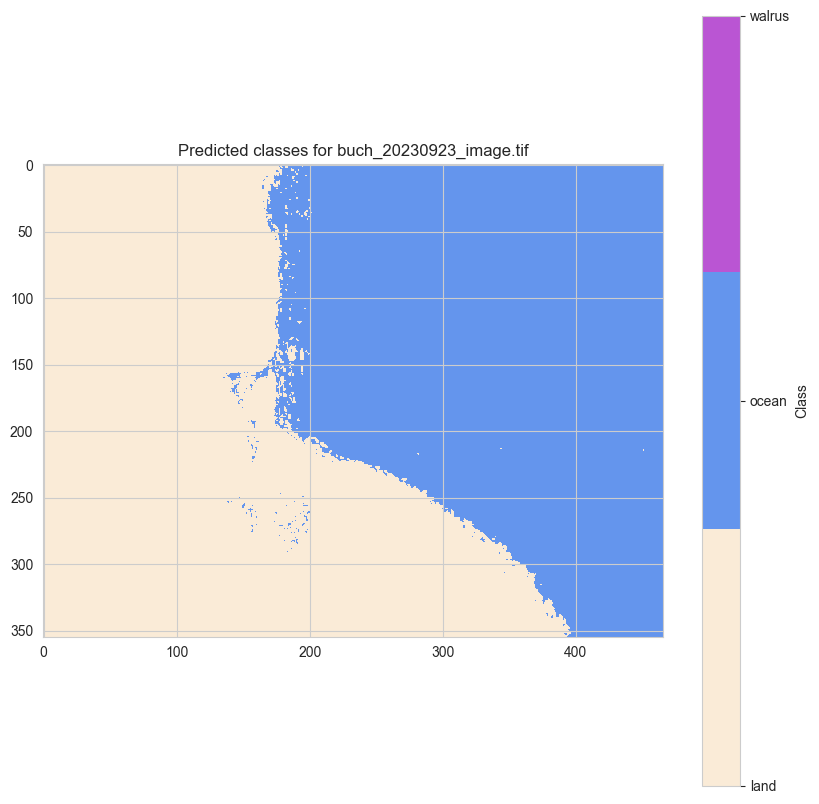

Labels present in moff_20230717_image.tif: ['land', 'ocean', 'walrus']


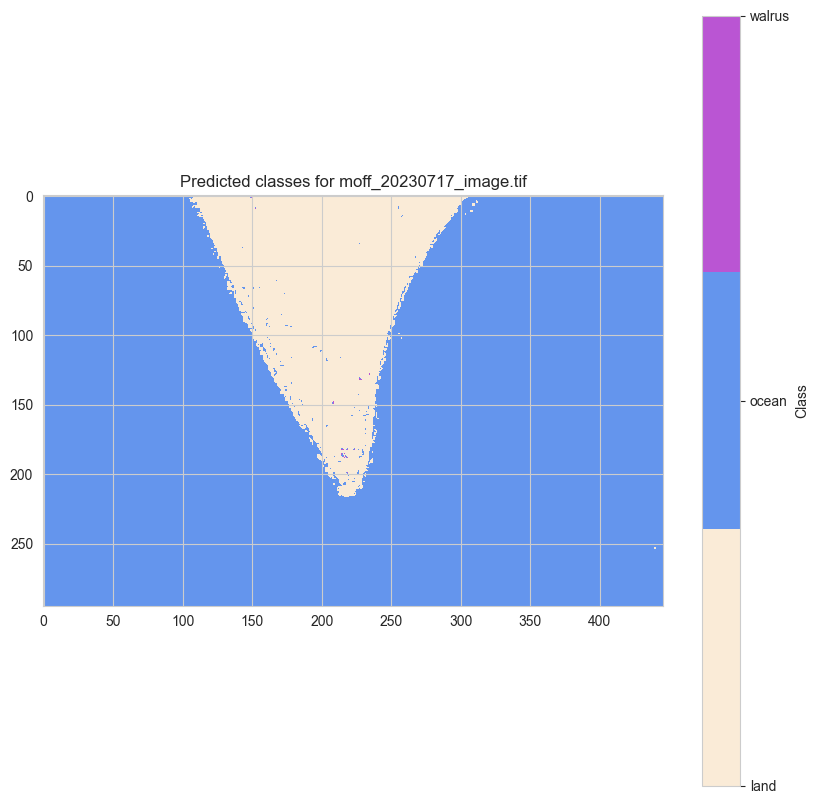

Labels present in pal_20230714_image.tif: ['land', 'ocean', 'walrus']


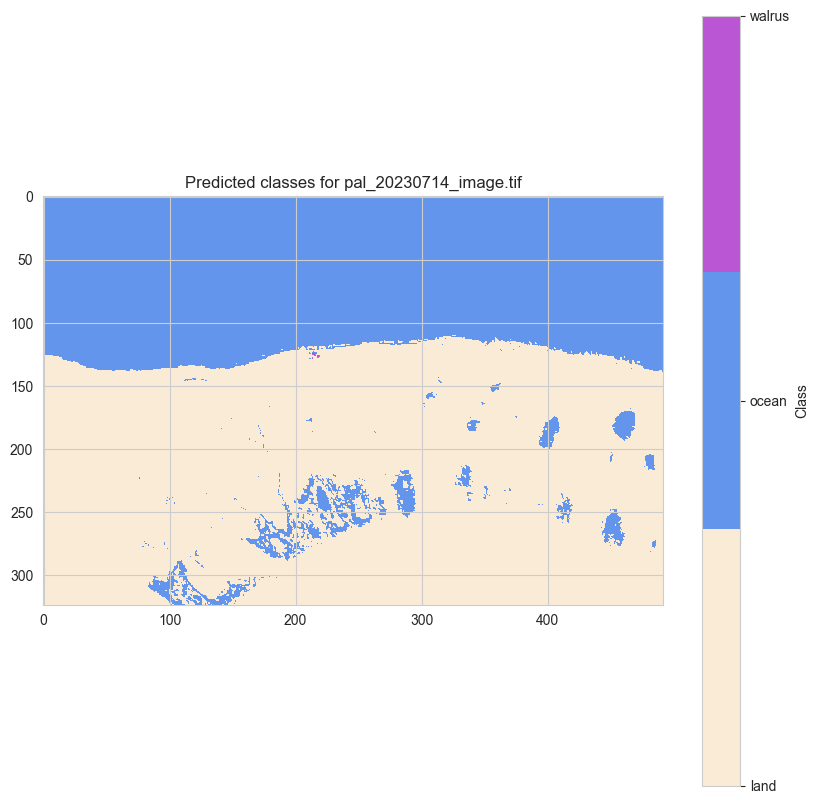

Labels present in pal_20230720_image.tif: ['land', 'ocean', 'walrus']


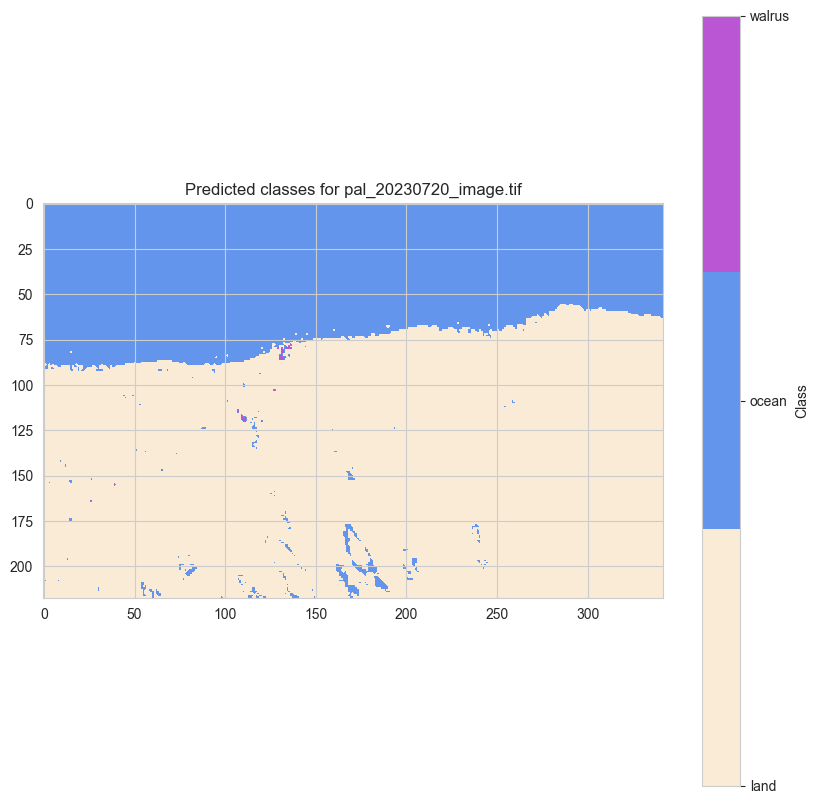

Labels present in pal_20230726_image.tif: ['land', 'ocean', 'walrus']


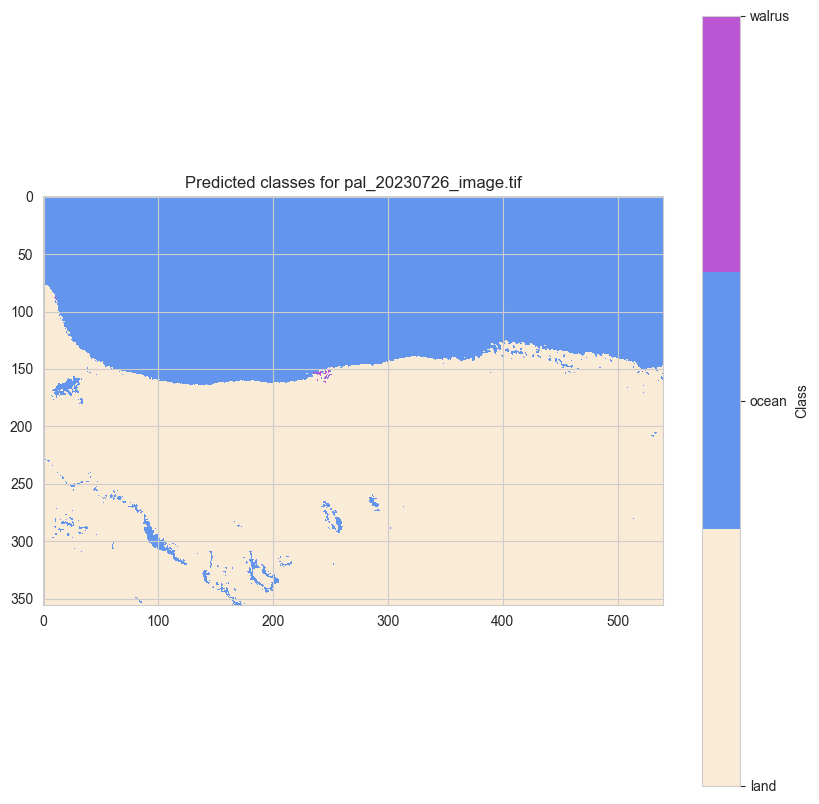

Labels present in sars_20230714_image.tif: ['land', 'ocean', 'walrus']


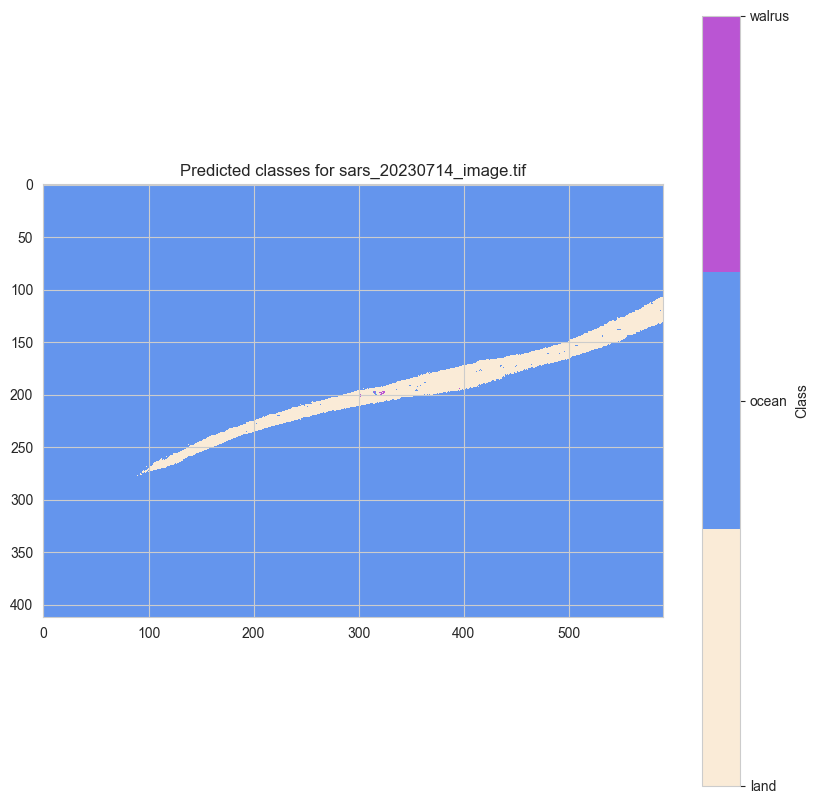

Labels present in sars_20230803_image.tif: ['land', 'ocean', 'walrus']


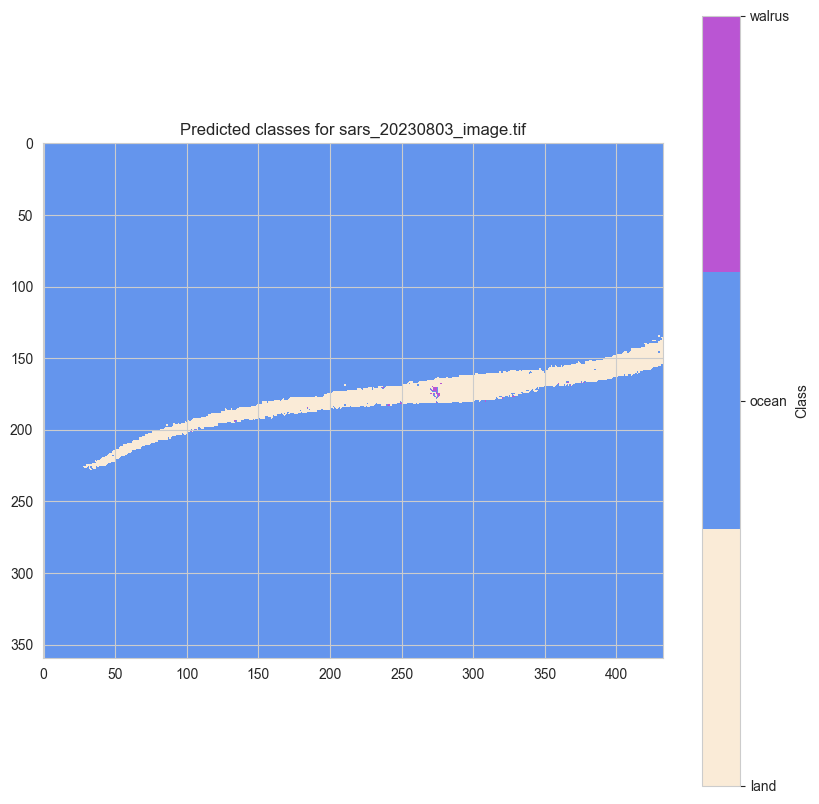

Labels present in tor_20230801_image.tif: ['land', 'ocean', 'walrus']


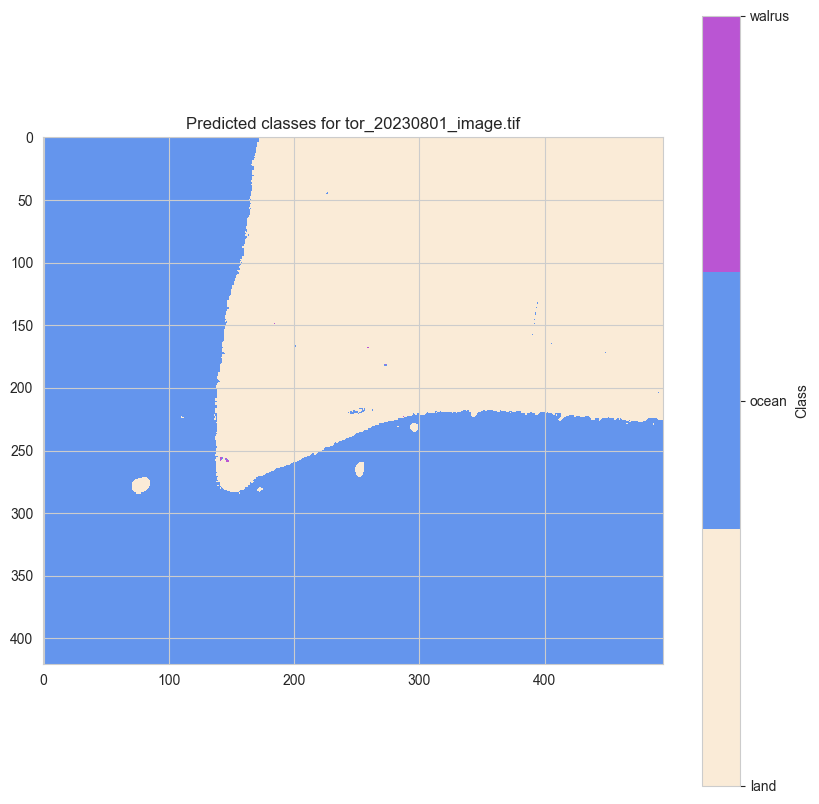

Labels present in tor_20230824_image.tif: ['land', 'ocean', 'walrus']


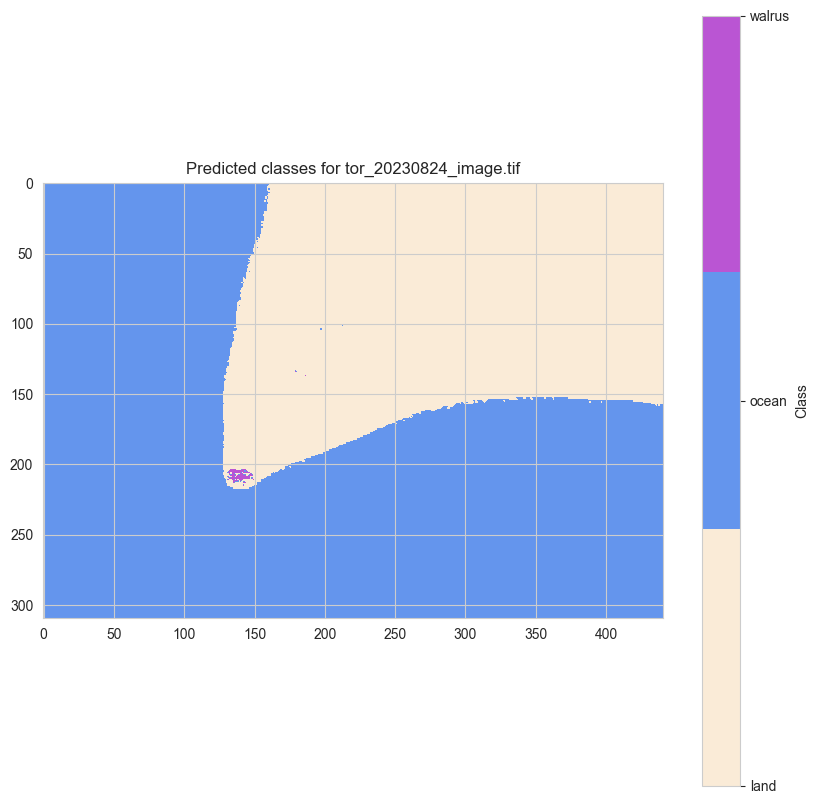

Labels present in tor_20230901_image.tif: ['land', 'ocean', 'walrus']


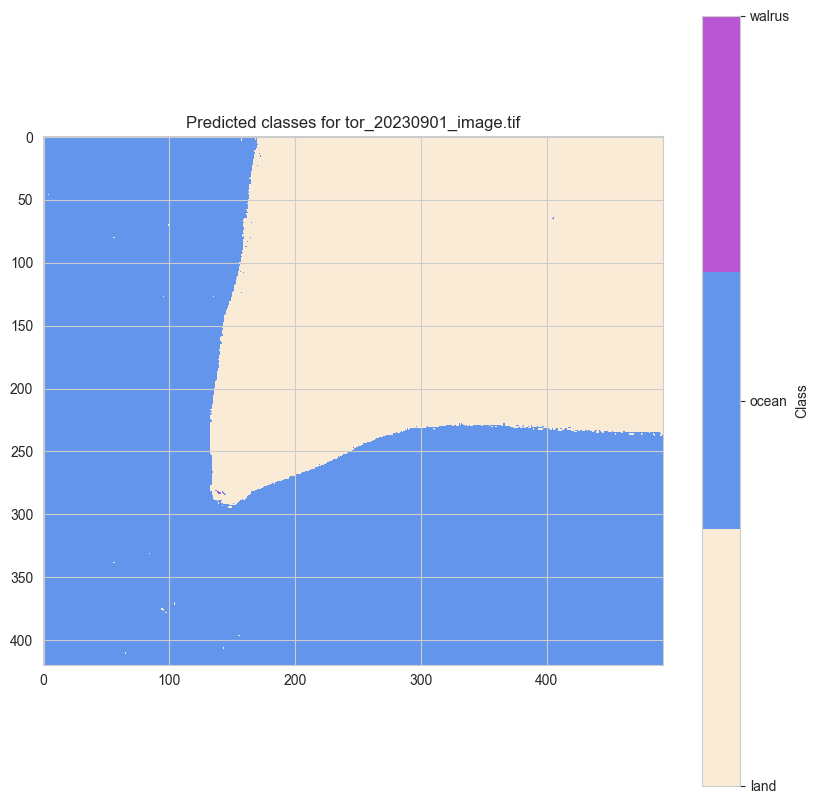

Labels present in tor_20230902_image.tif: ['land', 'ocean', 'walrus']


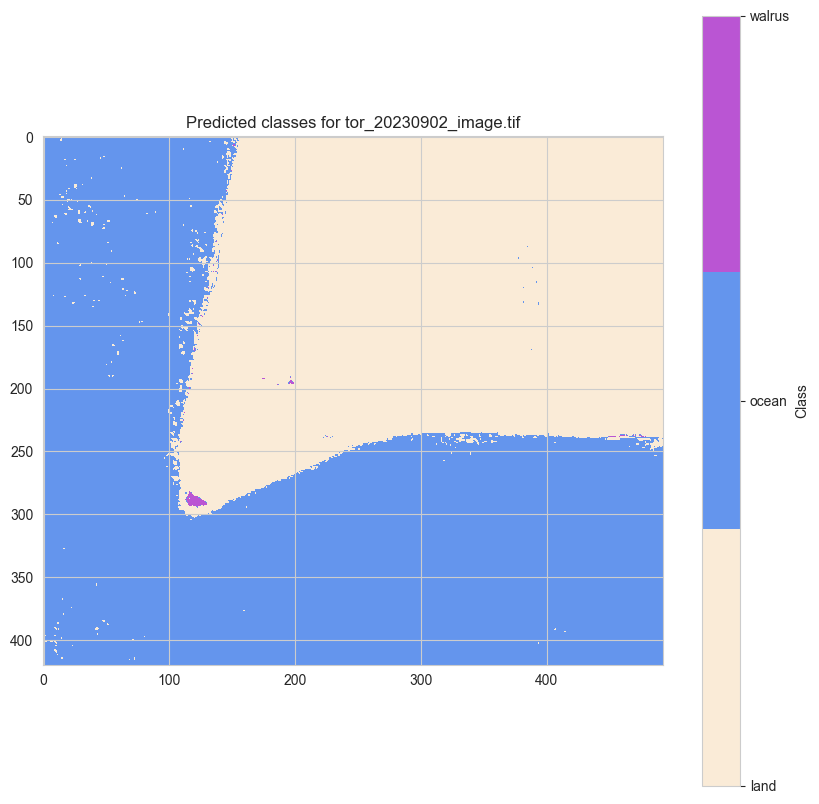

In [42]:
# Load the binary model
binary_model_filename = "binary_ocean_not_ocean_model.joblib"
binary_model = joblib.load(binary_model_filename)
print("Binary model loaded successfully")

# Load the walrus model
walrus_model_filename = "walrus_vs_land_model.joblib"
walrus_model = joblib.load(walrus_model_filename)
print("Walrus model loaded successfully")


def predict_image_combined(image_path, binary_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        height, width = image.shape[1], image.shape[2]

        # Reshape the image data correctly
        image_ocean = image[3:].reshape(5, -1).T
        image_walrus = image[:5].reshape(5, -1).T

        # Predict ocean vs. not ocean
        ocean_predictions = binary_model.predict(image_ocean)

        # Predict walrus vs. land for non-ocean pixels
        land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]
        walrus_predictions = np.zeros_like(ocean_predictions)
        walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])

        # Combine predictions
        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)

        return combined_predictions.reshape((height, width))


# Predict classes for images
predicted_images = {}
for image_path in file_pairs.keys():
    predicted_images[image_path] = predict_image_combined(image_path, binary_model, walrus_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_) - 1)

    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])

    # Highlight the labels present in the current image
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")

    plt.show()

In [ ]:
import glob
import os
import re
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from scipy.ndimage import label, binary_dilation
from rasterio.features import geometry_mask
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, classification_report, confusion_matrix
import seaborn as sns
import joblib
import rasterio
import geopandas as gpd
from rasterio.features import geometry_mas

In [22]:

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_training_files(image_paths, shapefile_paths):
    training_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if matching_shapefiles:
            training_pairs[image_path] = matching_shapefiles[0]

    return training_pairs

def pair_validation_files(unlabeled_image_paths, walrus_paths):
    validation_pairs = {}
    for image_path in unlabeled_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        if matching_walrus:
            validation_pairs[image_path] = matching_walrus[0]
        else:
            validation_pairs[image_path] = None  # Include images without walrus shapefiles

    return validation_pairs

training_pairs = pair_training_files(image_paths, shapefile_paths)
validation_pairs = pair_validation_files(unlabeled_image_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    features, labels, img_name = np.array(features), np.array(labels), np.array(img_name)
    
    # Debugging print statements
    print(f"Extracted {features.shape[0]} features, {labels.shape[0]} labels from {image_path}")
    
    return features, labels, img_name


def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile, None)
        if img_features.size > 0:
            features.append(img_features)
            labels.append(img_labels)
            image_name.append(img_name)

    if features and labels:
        features = np.vstack(features)
        labels = np.hstack(labels)
        image_name = np.hstack(image_name)
    else:
        features = np.array(features)
        labels = np.array(labels)
        image_name = np.array(image_name)

    print(f"Total features: {features.shape}, Total labels: {labels.shape}, Total image names: {image_name.shape}")
    
    return features, labels, image_name

features, labels, image_name = get_dataset(training_pairs)


# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})


Extracted 118050 features, 118050 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230714_image.tif
Extracted 186702 features, 186702 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230720_image.tif
Extracted 174450 features, 174450 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230731_image.tif
Extracted 74527 features, 74527 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\buch_20230923_image.tif
Extracted 67507 features, 67507 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\moff_20230717_image.tif
Extracted 63726 features, 63726 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230714_image.tif
Extracted 28744 features, 28744 labels from C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pal_20230720_image.tif
Extracted 78019 features, 78019 labels from C:\Users\Student\Documents\1

In [23]:
# Combine classes
dataset['combined_labels'] = dataset['labels'].apply(lambda x: 'land' if x in ['rock', 'ice', 'freshwater'] else ('walrus' if x in ['walrus_pure', 'walrus_mixed'] else x))
combined_le = LabelEncoder()
dataset['combined_encoded_labels'] = combined_le.fit_transform(dataset['combined_labels'])

def custom_train_test_split(df, label_col='combined_encoded_labels', test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df[label_col]):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        
        # Ensure that rare classes are in the training set
        if not all(cls in train_df[label_col].values for cls in [combined_le.transform(['walrus'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            print(f"Train set size: {train_df.shape}, Test set size: {test_df.shape}")
            return train_df, test_df
    return None, None

train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')


# Split the data
train_df, test_df = custom_train_test_split(dataset, label_col='combined_encoded_labels')
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, train_df['combined_encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'combined_labels', 'combined_encoded_labels', 'image_name']).values, test_df['combined_encoded_labels'].values

Train set size: (970828, 13), Test set size: (242707, 13)
Train set size: (970828, 13), Test set size: (242707, 13)


In [25]:
# Separate features for ocean vs. not ocean and land vs. walrus
X_train_ocean = X_train[:, 3:]  # Last 5 bands for ocean vs. not ocean
X_test_ocean = X_test[:, 3:]
X_train_walrus = X_train[:, :5]  # First 5 bands for land vs. walrus
X_test_walrus = X_test[:, :5]

# Train the binary classifier (ocean vs. not ocean)
binary_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

binary_model.fit(X_train_ocean, y_train)

# Debugging print statements
print(f"Binary model trained on {X_train_ocean.shape} features")

# Save the binary model
binary_model_filename = "binary_ocean_not_ocean_model.joblib"
joblib.dump(binary_model, binary_model_filename)

Binary model trained on (970828, 5) features


['binary_ocean_not_ocean_model.joblib']

In [11]:
# Filter land and walrus pixels for training
not_ocean_mask = train_df['combined_labels'] == 'land'
X_train_not_ocean = X_train_walrus[not_ocean_mask]
y_train_not_ocean = train_df.loc[not_ocean_mask, 'encoded_labels'].values

# Train the walrus classifier (land vs. walrus)
walrus_model = VotingClassifier(estimators=[
    ('knn', KNeighborsClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('xgb', XGBClassifier(eval_metric='logloss', random_state=42))
], voting='soft')

non_ocean_mask_train = y_train != combined_le.transform(['ocean'])[0]
walrus_model.fit(X_train_walrus[non_ocean_mask_train], y_train[non_ocean_mask_train])

# Debugging print statements
print(f"Walrus model trained on {X_train_walrus[non_ocean_mask_train].shape} features")   

# Save the walrus model
walrus_model_filename = "walrus_vs_land_model.joblib"
joblib.dump(walrus_model, walrus_model_filename)

Walrus model trained on (347636, 5) features


['walrus_vs_land_model.joblib']

Image shape: (8, 180, 293)
Image ocean shape: (52740, 5)
Image walrus shape: (52740, 5)
Ocean predictions made for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\buch_20230825_image.tif
Walrus predictions made for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\buch_20230825_image.tif
Ocean predictions shape: (52740,)
Land mask shape: (52740,)
Walrus predictions shape: (52740,)
Combined predictions shape: (52740,)
Valid prediction for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\buch_20230825_image.tif: shape (180, 293)
Image shape: (8, 180, 285)
Image ocean shape: (51300, 5)
Image walrus shape: (51300, 5)
Ocean predictions made for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\buch_20230901_image.tif
Walrus predictions made for C:\Users\Student\Documents\101_walrus_data\train\clipped_unlabeled\buch_20230901_image.tif
Ocean predictions shape: (51300,)
Land mask shape: (51300,)
Walrus predictions shape: (5

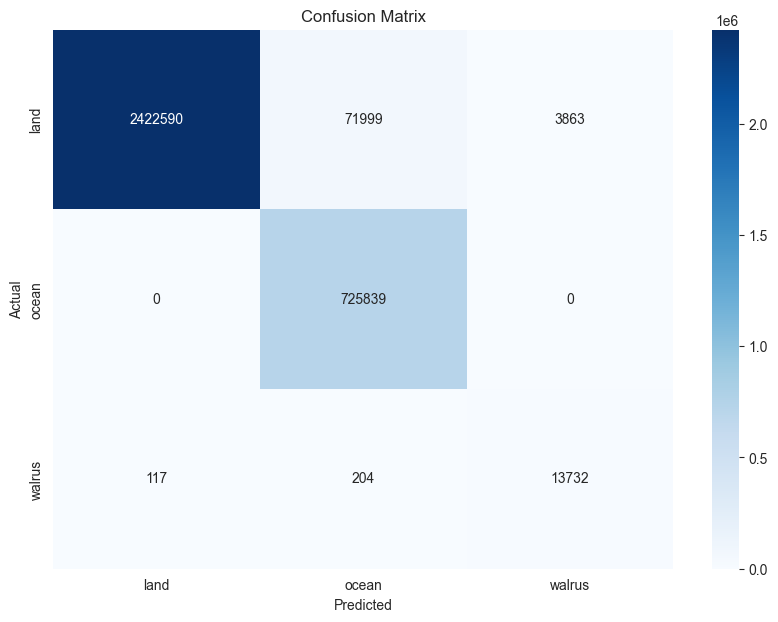

In [26]:
# Post-processing functions to remove speckles
def connected_component_analysis(prediction, min_size=50):
    labeled_array, num_features = label(prediction, return_num=True)
    sizes = np.bincount(labeled_array.ravel())
    mask_sizes = sizes >= min_size
    mask_sizes[0] = 0  # Ensure background is not considered
    cleaned_prediction = mask_sizes[labeled_array]
    return cleaned_prediction

def proximity_filter(prediction, ocean_mask, radius=50):
    structure = np.ones((radius, radius), dtype=bool)
    if ocean_mask.ndim == 2:
        dilated_ocean = binary_dilation(ocean_mask, structure=structure)
    else:
        raise ValueError("ocean_mask must be a 2D array")
    
    walrus_mask = prediction == combined_le.transform(['walrus'])[0]
    walrus_mask[~dilated_ocean] = False
    prediction[walrus_mask] = combined_le.transform(['walrus'])[0]
    prediction[(prediction == combined_le.transform(['walrus'])[0]) & (~walrus_mask)] = combined_le.transform(['land'])[0]
    return prediction


def post_process_prediction(prediction, original_shape):
    if prediction.size != original_shape[0] * original_shape[1]:
        raise ValueError(f"Prediction size {prediction.size} does not match the original shape {original_shape[0] * original_shape[1]}")

    prediction = prediction.reshape(original_shape)
    ocean_mask = prediction == combined_le.transform(['ocean'])[0]
    land_mask = prediction == combined_le.transform(['land'])[0]

    ocean_mask = connected_component_analysis(ocean_mask)
    land_mask = connected_component_analysis(land_mask)

    prediction[ocean_mask] = combined_le.transform(['ocean'])[0]
    prediction[land_mask] = combined_le.transform(['land'])[0]

    prediction = proximity_filter(prediction, ocean_mask)

    return prediction


def predict_image(image_path, ocean_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        original_shape = (src.height, src.width)
        num_pixels = src.height * src.width

        # Ensure correct reshaping for ocean model
        image_ocean = image[3:].reshape((image.shape[1] * image.shape[2], -1))
        image_walrus = image[:5].reshape((image.shape[1] * image.shape[2], -1))

        # Debugging statements
        print(f"Image shape: {image.shape}")
        print(f"Image ocean shape: {image_ocean.shape}")
        print(f"Image walrus shape: {image_walrus.shape}")

        if image_ocean.size == 0 or image_walrus.size == 0:
            raise ValueError(f"Empty feature arrays for image: {image_path}")

        # Make predictions
        try:
            ocean_predictions = ocean_model.predict(image_ocean)
            print(f"Ocean predictions made for {image_path}")
        except Exception as e:
            print(f"Error in ocean predictions for {image_path}: {e}")
            return np.array([])  # Return empty array if prediction fails

        try:
            land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]
            walrus_predictions = np.zeros_like(ocean_predictions)
            walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])
            print(f"Walrus predictions made for {image_path}")
        except Exception as e:
            print(f"Error in walrus predictions for {image_path}: {e}")
            return np.array([])  # Return empty array if prediction fails

        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)

        # Debugging statements
        print(f"Ocean predictions shape: {ocean_predictions.shape}")
        print(f"Land mask shape: {land_mask.shape}")
        print(f"Walrus predictions shape: {walrus_predictions.shape}")
        print(f"Combined predictions shape: {combined_predictions.shape}")

        if combined_predictions.size != num_pixels:
            raise ValueError(f"Combined predictions size {combined_predictions.size} does not match the number of pixels {num_pixels}")

        combined_predictions = post_process_prediction(combined_predictions, original_shape)

        return combined_predictions


  
# Evaluate the models on the test set
test_image_paths = [image_path for image_path, _ in file_pairs.items() if image_path in unlabeled_image_paths]

def extract_true_labels(image_path, walrus_shapefile):
    # Read the image
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform
        height, width = src.height, src.width

    # Read the walrus shapefile
    gdf = gpd.read_file(walrus_shapefile)

    # Create a mask for walrus areas
    walrus_mask = geometry_mask(gdf.geometry, transform=transform, invert=True, out_shape=(height, width))

    # Create a label array
    labels = np.full((height, width), combined_le.transform(['land'])[0], dtype=np.int32)
    
    # Set walrus areas in the label array
    labels[walrus_mask] = combined_le.transform(['walrus'])[0]

    # Identify ocean areas (assuming pixels with all zeros are ocean)
    ocean_mask = np.all(image == 0, axis=0)
    labels[ocean_mask] = combined_le.transform(['ocean'])[0]

    return labels.flatten()

def evaluate_model(validation_pairs, ocean_model, walrus_model):
    y_true = []
    y_pred = []

    for image_path, walrus_shapefile in validation_pairs.items():
        predicted = predict_image(image_path, ocean_model, walrus_model)
        if predicted.size != 0:
            if walrus_shapefile:
                true_labels = extract_true_labels(image_path, walrus_shapefile)
                y_true.extend(true_labels)
                y_pred.extend(predicted.flatten())
                print(f"Valid prediction for {image_path}: shape {predicted.shape}")
            else:
                print(f"No walrus shapefile for {image_path}, using predicted labels")
                # For images without walrus shapefiles, we'll use the predicted labels
                # This assumes that if there's no walrus shapefile, there are no walrus in the image
                y_true.extend(predicted.flatten())
                y_pred.extend(predicted.flatten())
        else:
            print(f"No valid prediction for {image_path}")

    if len(y_true) == 0 or len(y_pred) == 0:
        raise ValueError("No valid predictions made. Check the models and input data.")

    return np.array(y_true), np.array(y_pred)

# Run the evaluation function
try:
    y_true, y_pred_combined = evaluate_model(validation_pairs, binary_model, walrus_model)
    
    # Calculate Evaluation Metrics
    accuracy = accuracy_score(y_true, y_pred_combined)
    precision = precision_score(y_true, y_pred_combined, average='weighted')
    recall = recall_score(y_true, y_pred_combined, average='weighted')
    f1 = f1_score(y_true, y_pred_combined, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred_combined)

    # Print Metrics
    print("Combined Model (Post-Processed)")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"Cohen's Kappa: {kappa}")

    print("\nClassification Report for Combined Model (Post-Processed):")
    print(classification_report(y_true, y_pred_combined, target_names=combined_le.classes_))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_combined)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=combined_le.classes_, 
                yticklabels=combined_le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

except ValueError as e:
    print(e)

Labels present in buch_20230714_image.tif: ['land', 'ocean', 'walrus']


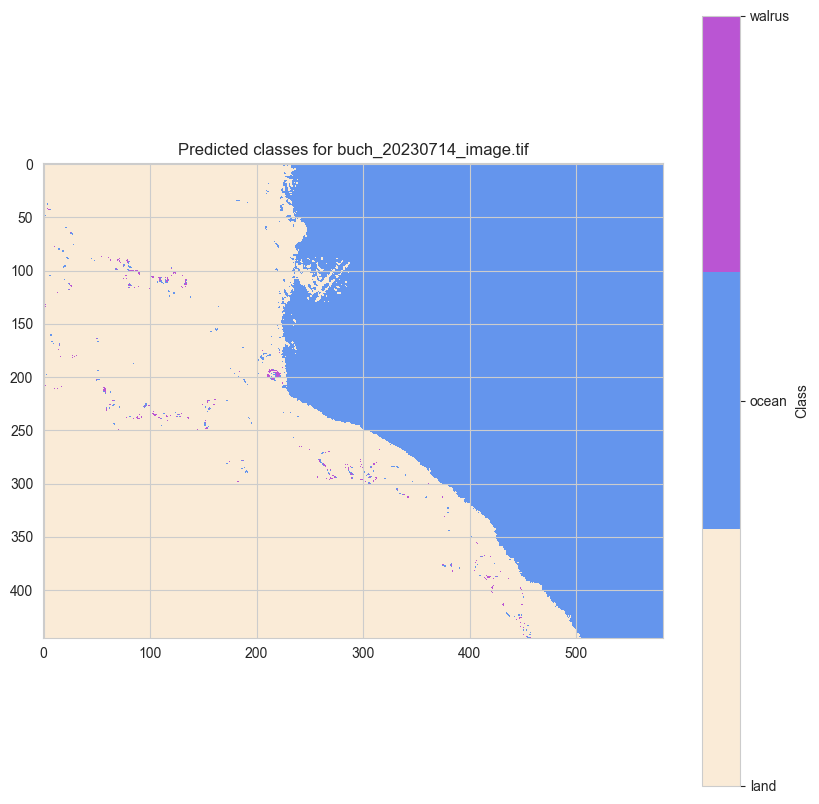

Labels present in buch_20230720_image.tif: ['land', 'ocean', 'walrus']


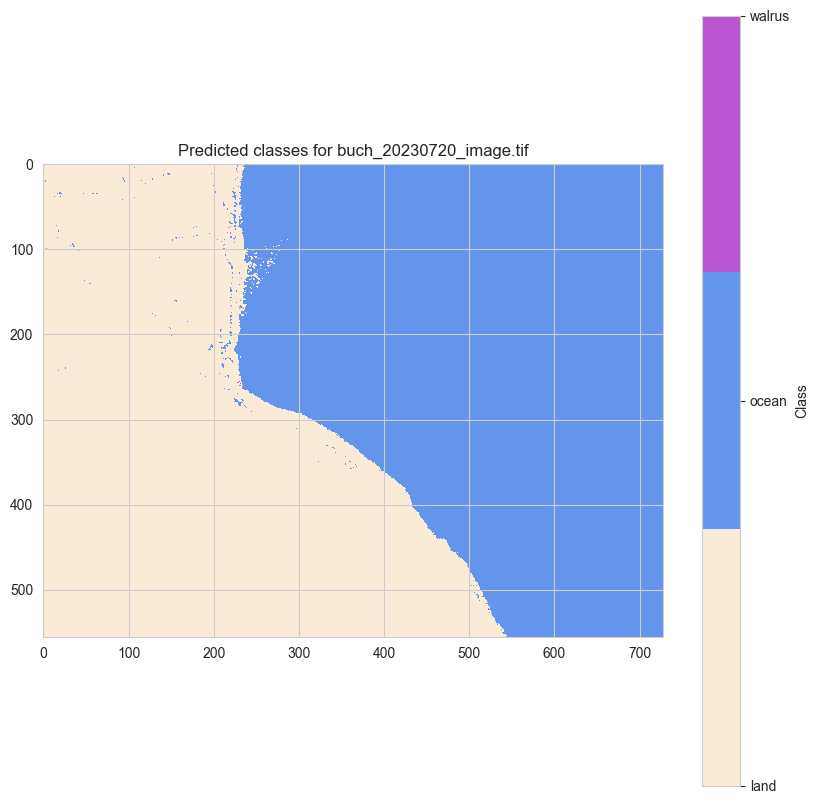

Labels present in buch_20230731_image.tif: ['land', 'ocean', 'walrus']


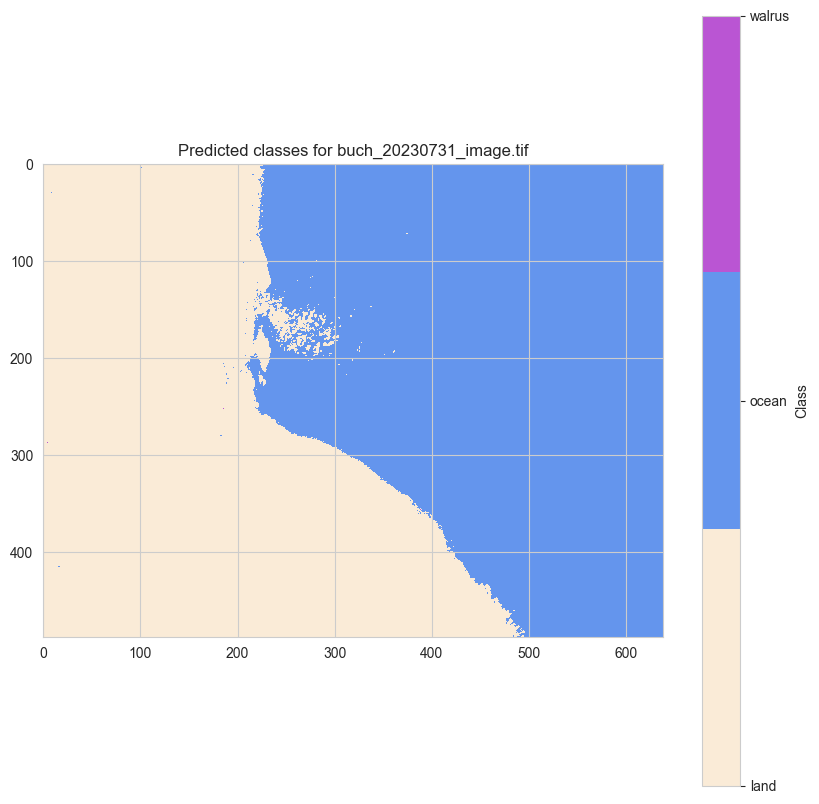

Labels present in buch_20230923_image.tif: ['land', 'ocean']


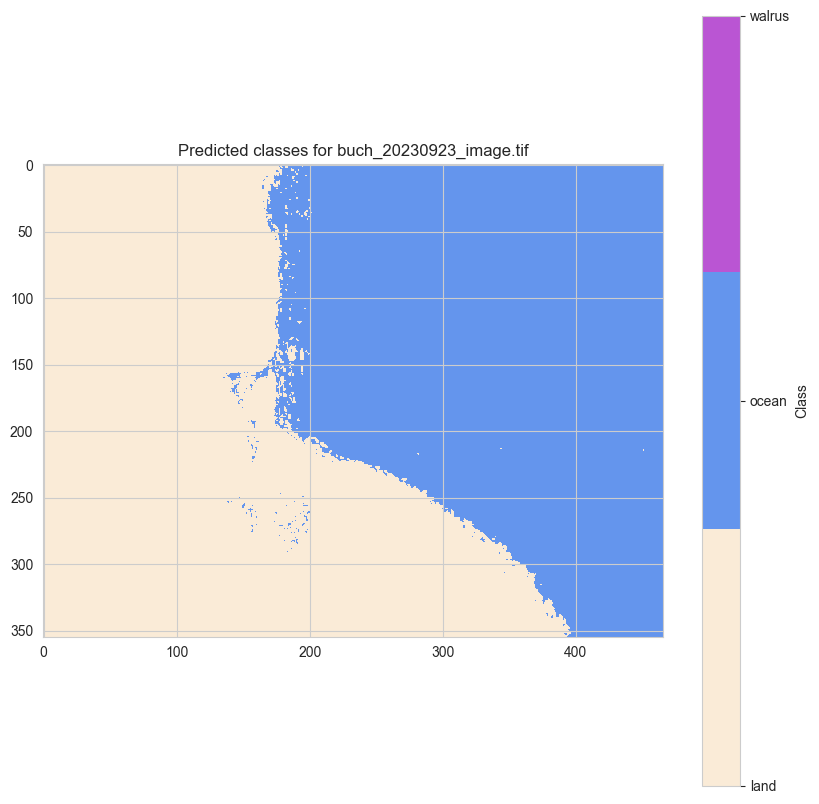

Labels present in moff_20230717_image.tif: ['land', 'ocean', 'walrus']


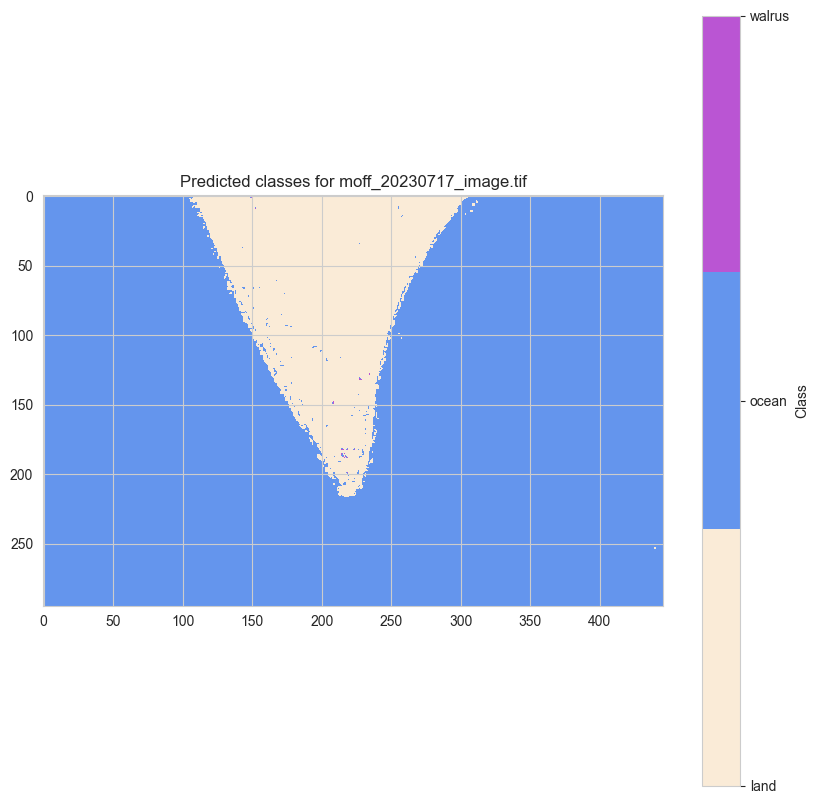

Labels present in pal_20230714_image.tif: ['land', 'ocean', 'walrus']


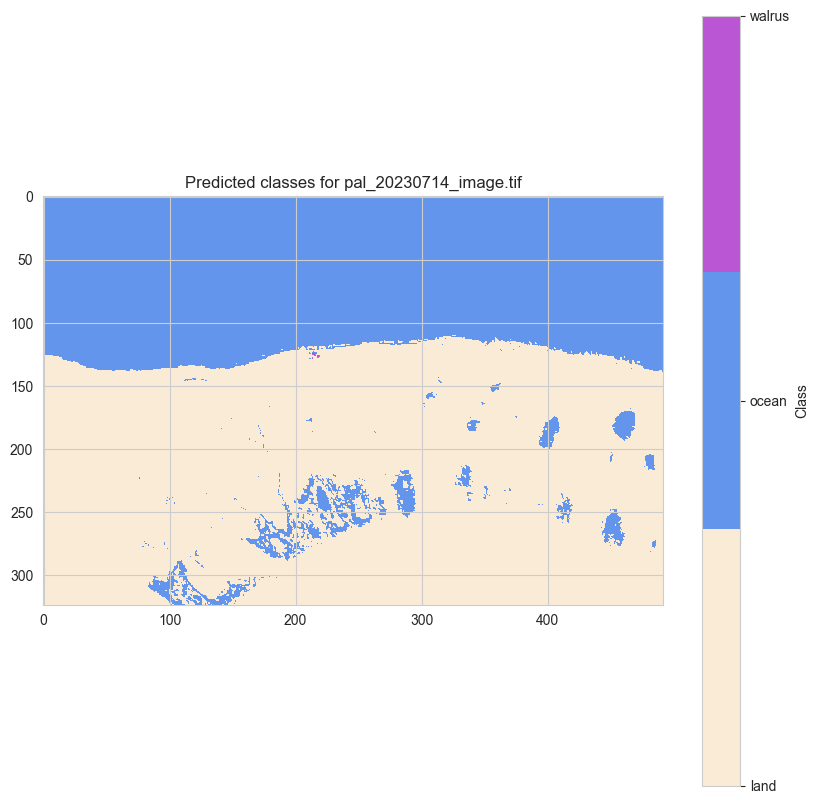

Labels present in pal_20230720_image.tif: ['land', 'ocean', 'walrus']


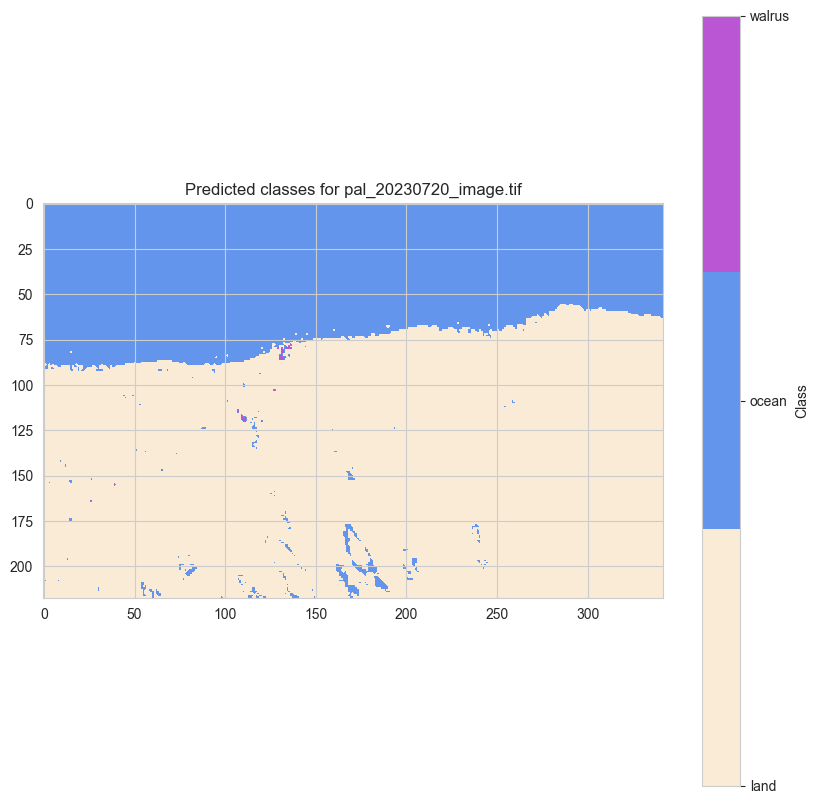

Labels present in pal_20230726_image.tif: ['land', 'ocean', 'walrus']


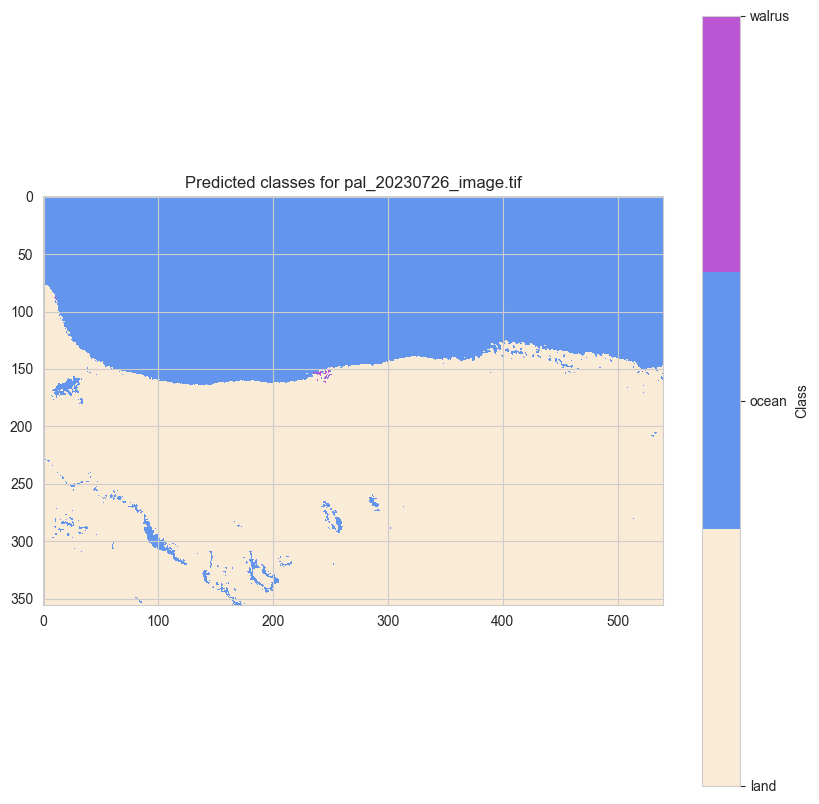

Labels present in sars_20230714_image.tif: ['land', 'ocean', 'walrus']


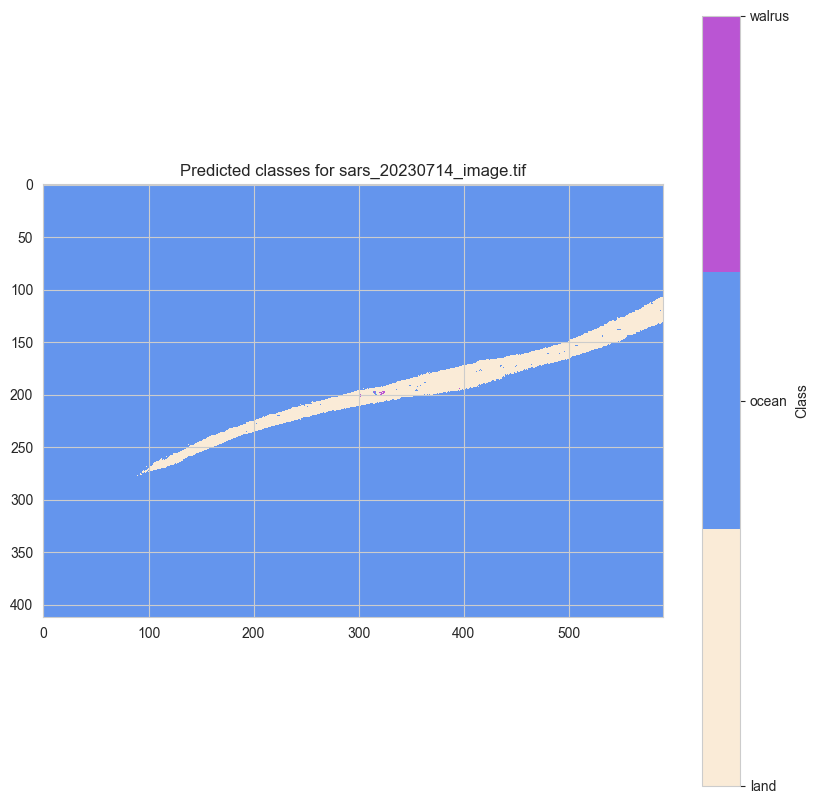

Labels present in sars_20230803_image.tif: ['land', 'ocean', 'walrus']


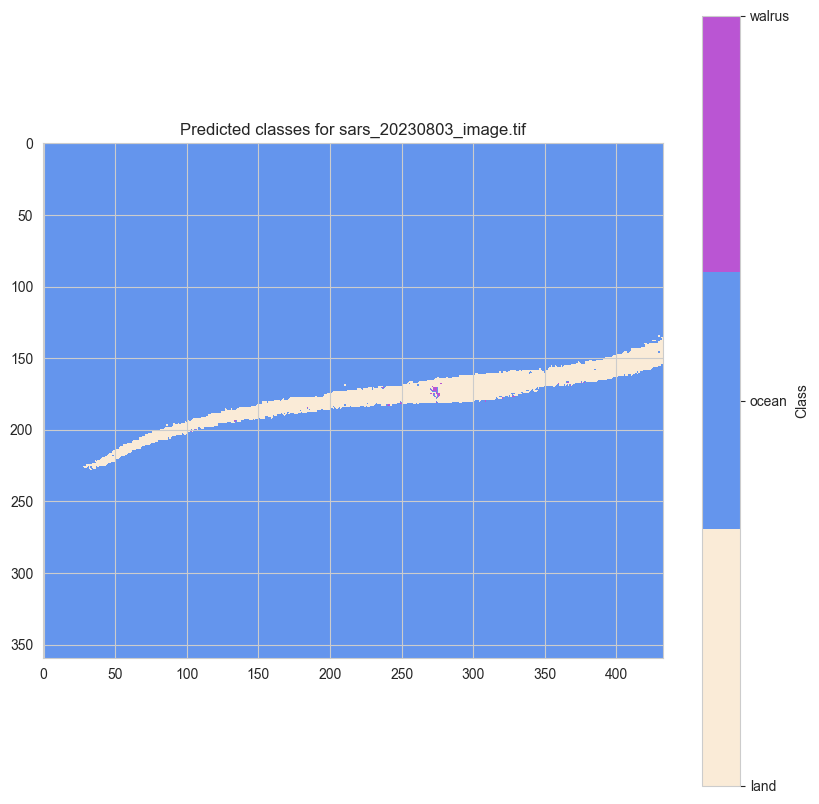

Labels present in tor_20230801_image.tif: ['land', 'ocean', 'walrus']


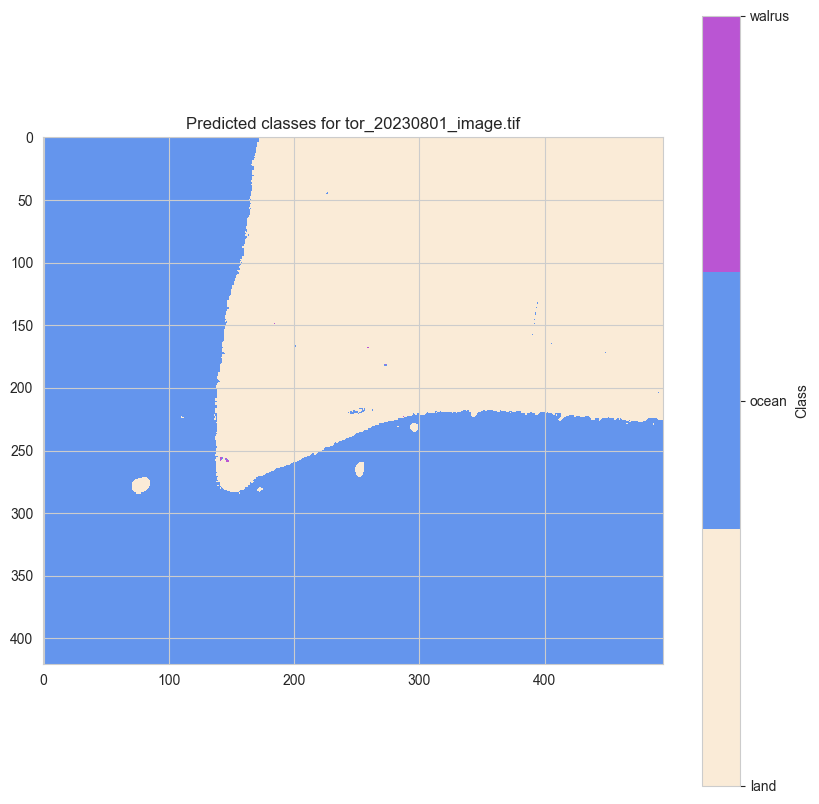

Labels present in tor_20230824_image.tif: ['land', 'ocean', 'walrus']


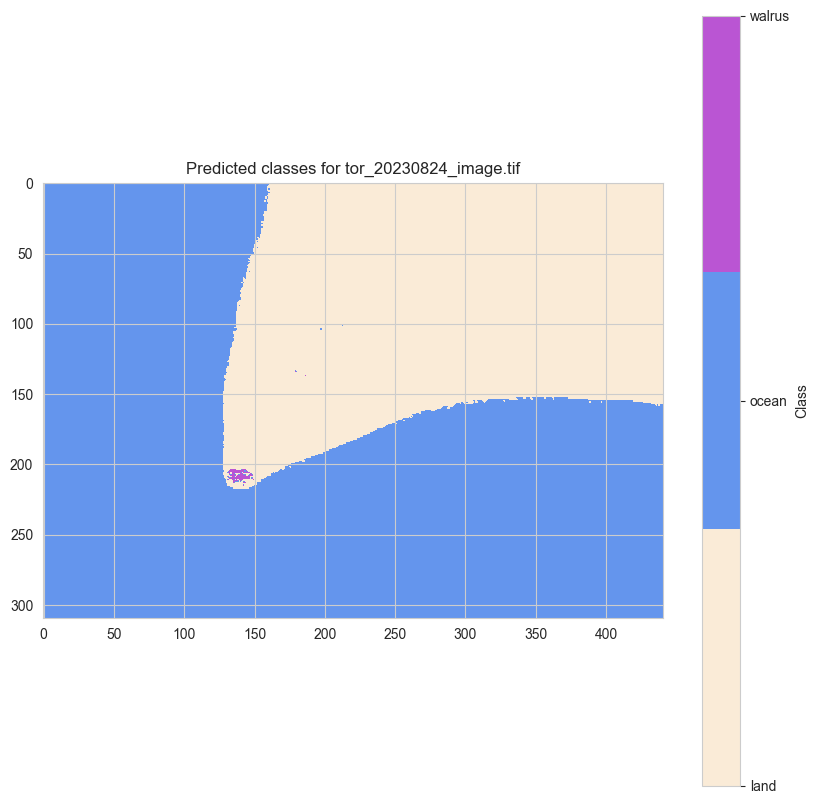

Labels present in tor_20230901_image.tif: ['land', 'ocean', 'walrus']


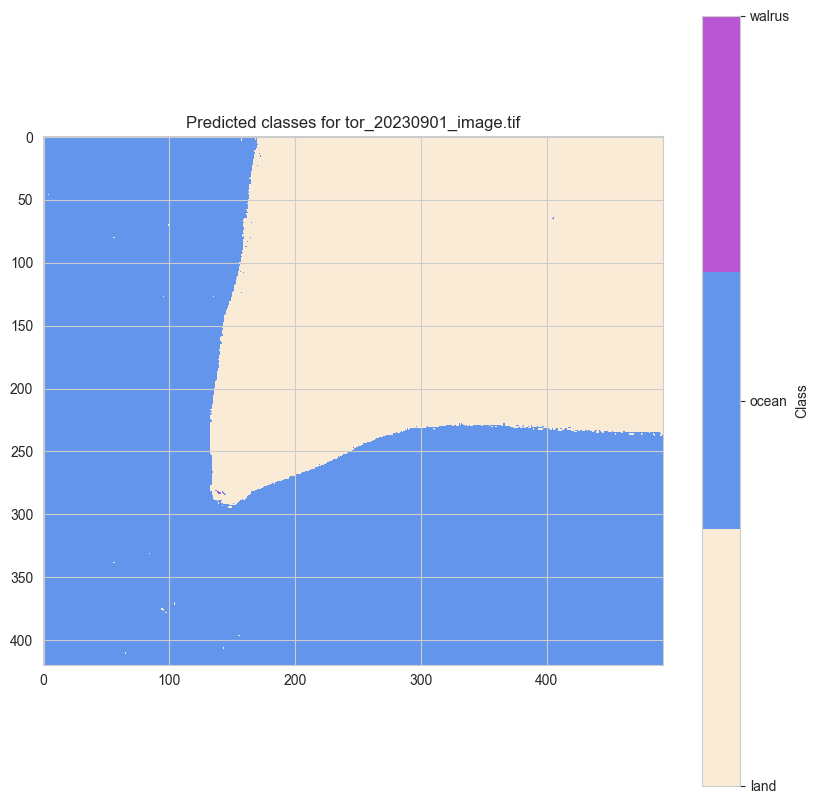

Labels present in tor_20230902_image.tif: ['land', 'ocean', 'walrus']


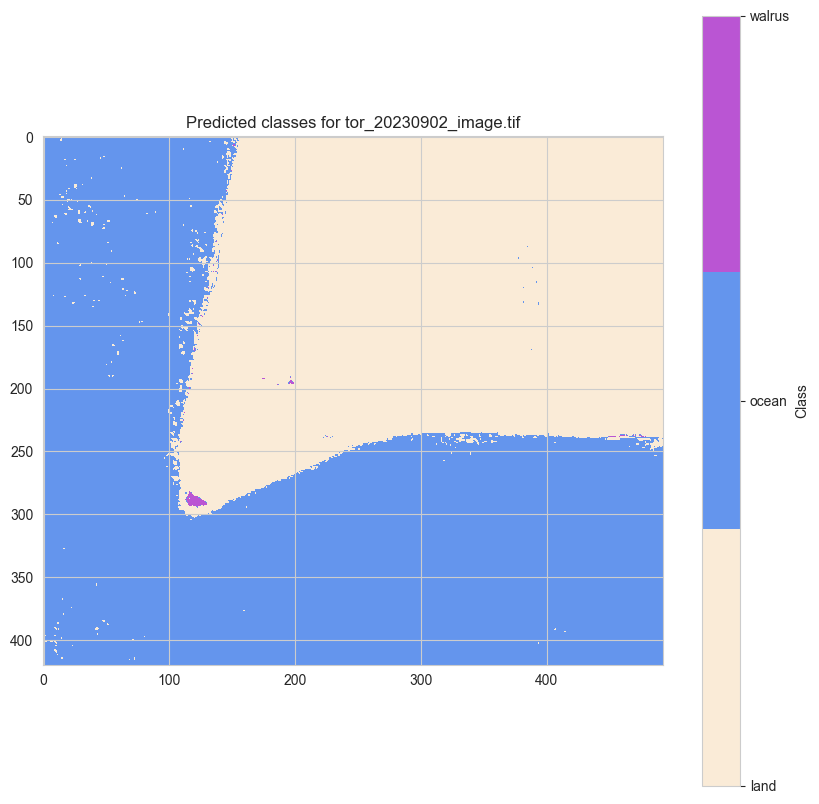

In [28]:
# Define a color map for the labels
label_colors = {
    'ocean': 'cornflowerblue',
    'land': 'antiquewhite',
    'walrus': 'mediumorchid'
}

# Create a fixed color map based on combined labels
cmap = mcolors.ListedColormap([label_colors[label] for label in combined_le.classes_])

# Function to predict classes for a given image using both models
def predict_image_combined(image_path, binary_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_ocean = image[3:].reshape((5, -1)).T  # Last 5 bands for binary model
        image_walrus = image[:5].reshape((5, -1)).T  # First 5 bands for walrus model
        
        # Predict ocean vs. not ocean
        ocean_predictions = binary_model.predict(image_ocean)
        
        # Predict walrus vs. land for non-ocean pixels
        land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]
        walrus_predictions = np.zeros_like(ocean_predictions)
        walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])
        
        # Combine predictions
        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)
        
        return combined_predictions.reshape((src.height, src.width))

# Predict classes for images with attached shapefiles
predicted_images = {}
for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
    predicted_images[image_path] = predict_image_combined(image_path, binary_model, walrus_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])
    
    # Highlight the labels present in the current image
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()

In [29]:
# Load the binary model
binary_model_filename = "binary_ocean_not_ocean_model.joblib"
binary_model = joblib.load(binary_model_filename)
print("Binary model loaded successfully")

# Load the walrus model
walrus_model_filename = "walrus_vs_land_model.joblib"
walrus_model = joblib.load(walrus_model_filename)
print("Walrus model loaded successfully")

Binary model loaded successfully
Walrus model loaded successfully


Labels present in buch_20230714_image.tif: ['land', 'ocean', 'walrus']


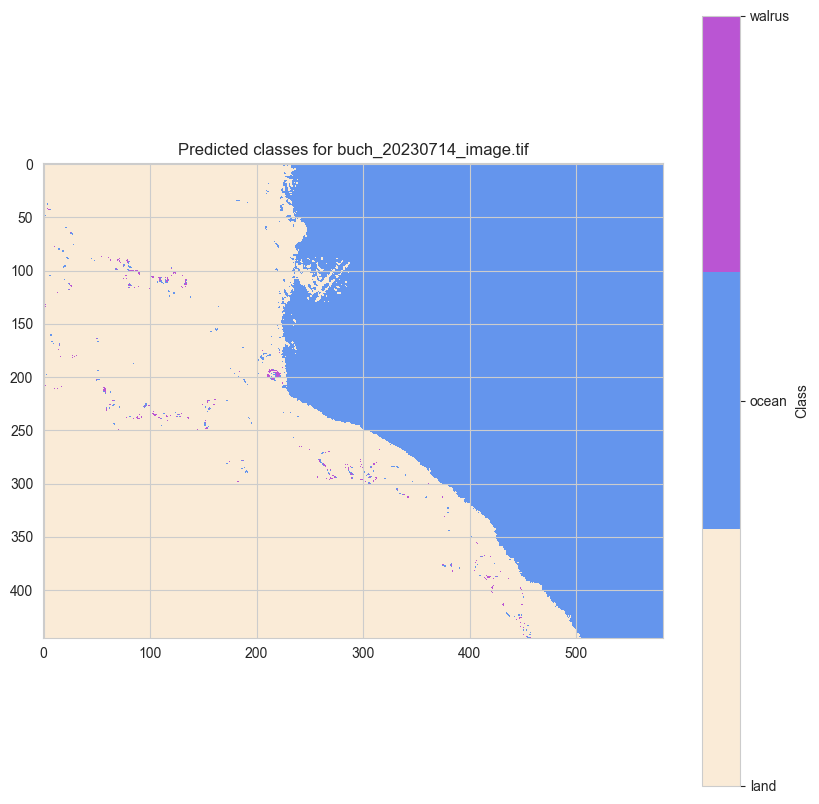

Labels present in buch_20230720_image.tif: ['land', 'ocean', 'walrus']


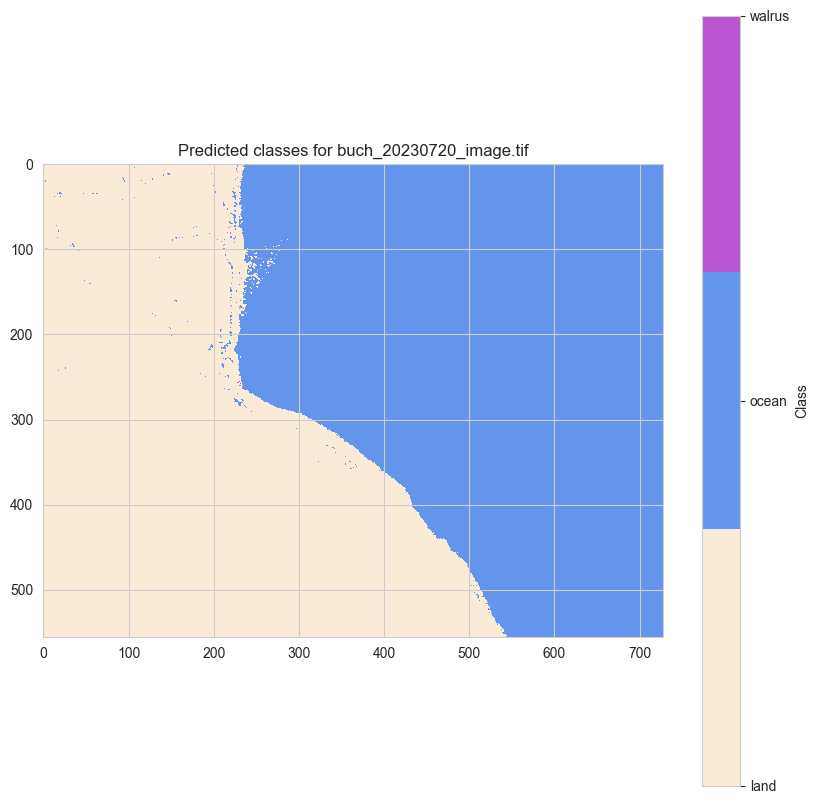

Labels present in buch_20230731_image.tif: ['land', 'ocean', 'walrus']


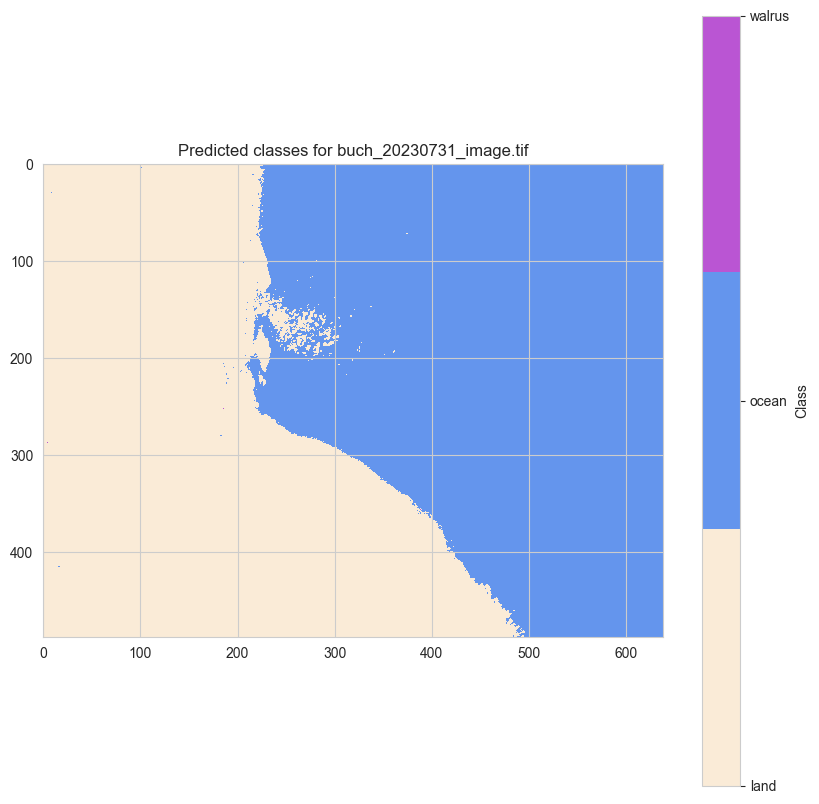

Labels present in buch_20230923_image.tif: ['land', 'ocean']


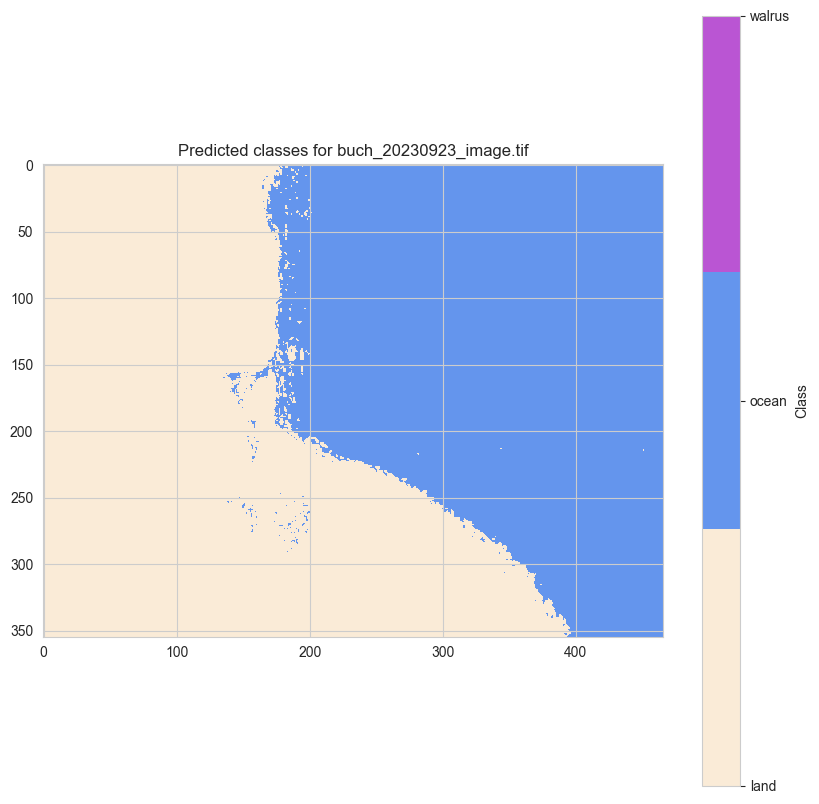

Labels present in moff_20230717_image.tif: ['land', 'ocean', 'walrus']


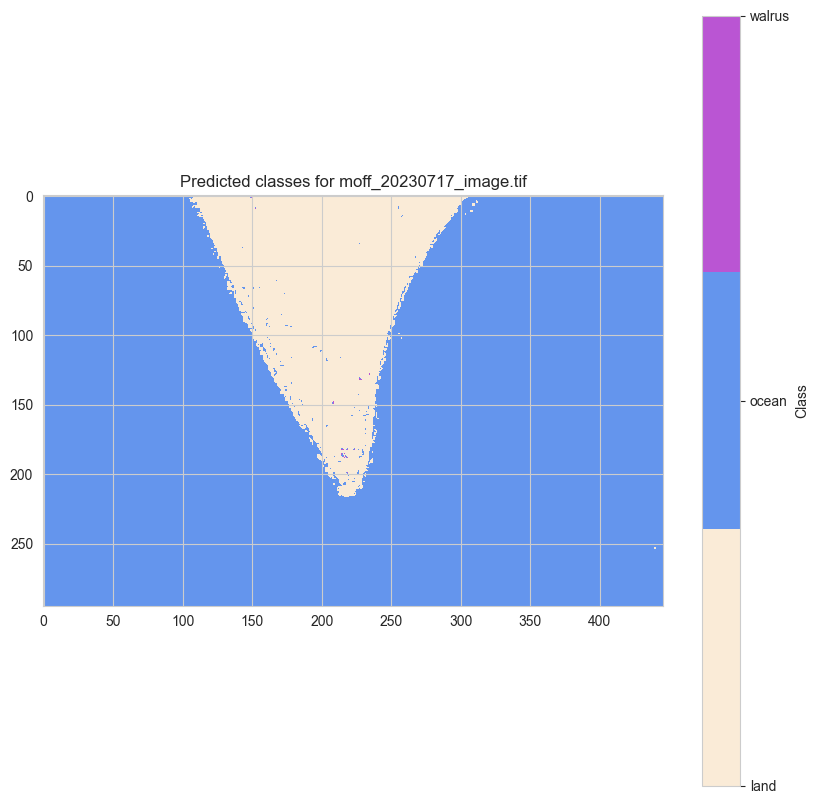

Labels present in pal_20230714_image.tif: ['land', 'ocean', 'walrus']


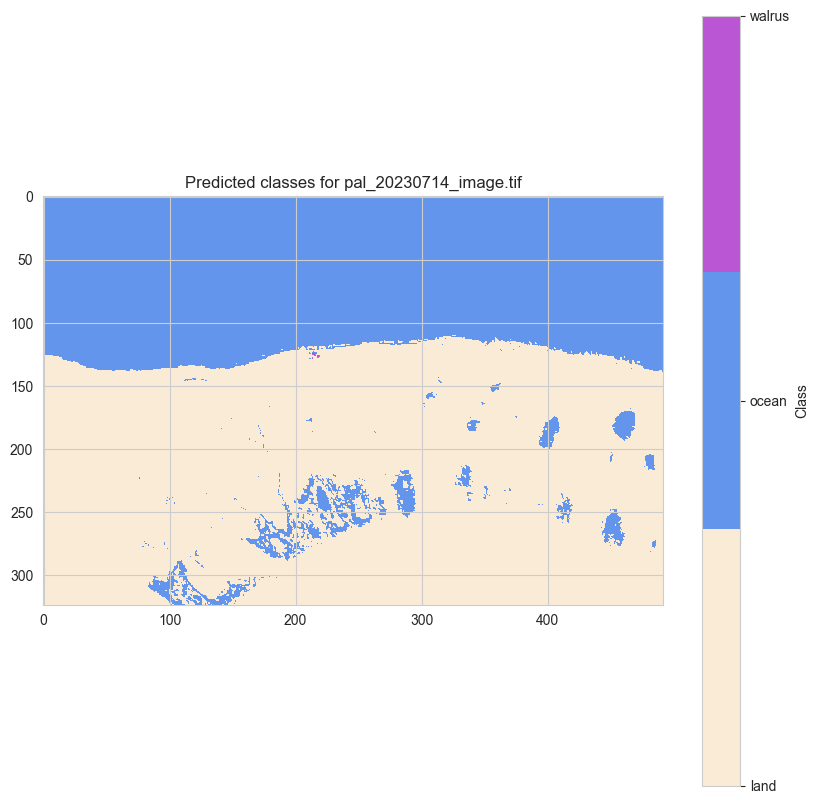

Labels present in pal_20230720_image.tif: ['land', 'ocean', 'walrus']


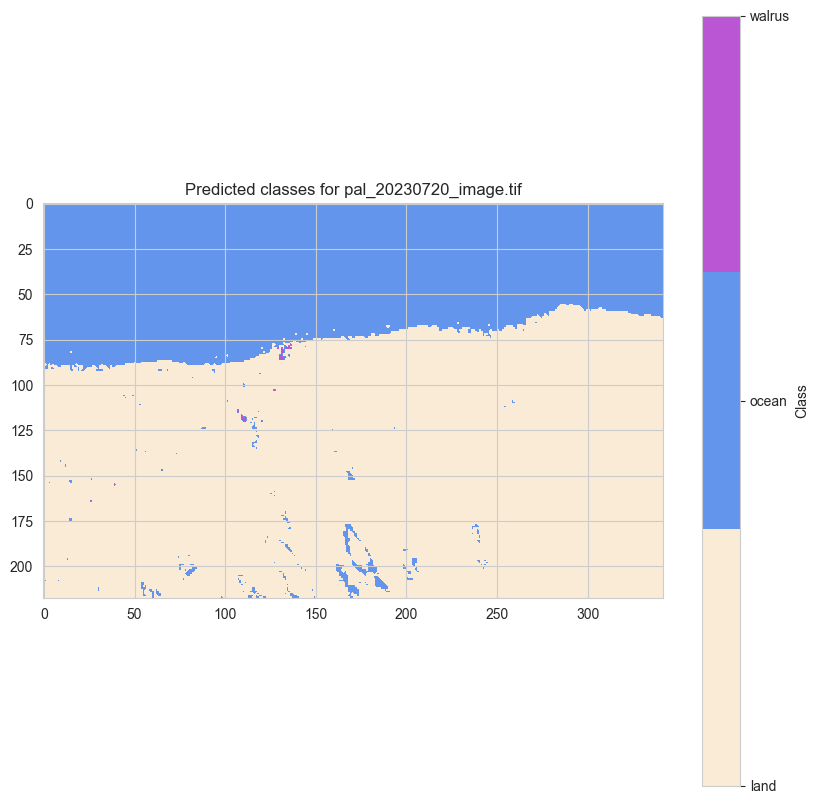

Labels present in pal_20230726_image.tif: ['land', 'ocean', 'walrus']


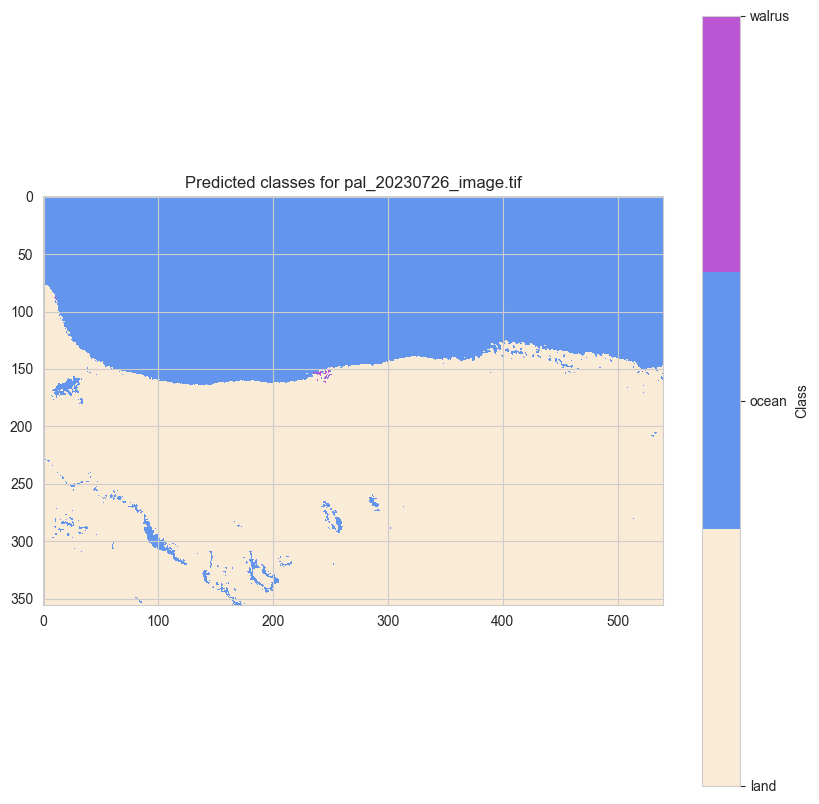

Labels present in sars_20230714_image.tif: ['land', 'ocean', 'walrus']


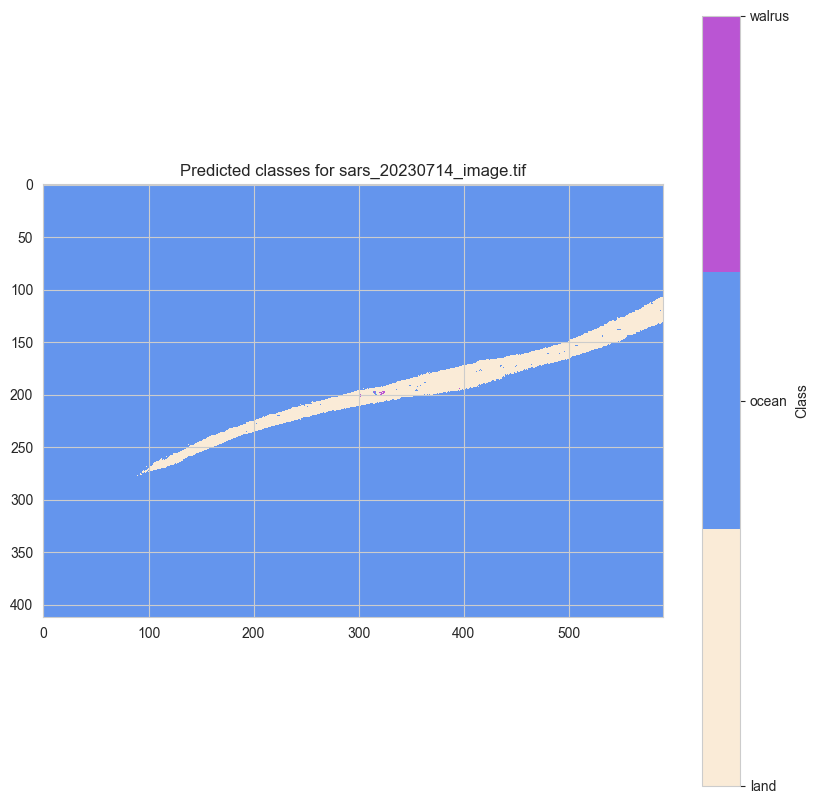

Labels present in sars_20230803_image.tif: ['land', 'ocean', 'walrus']


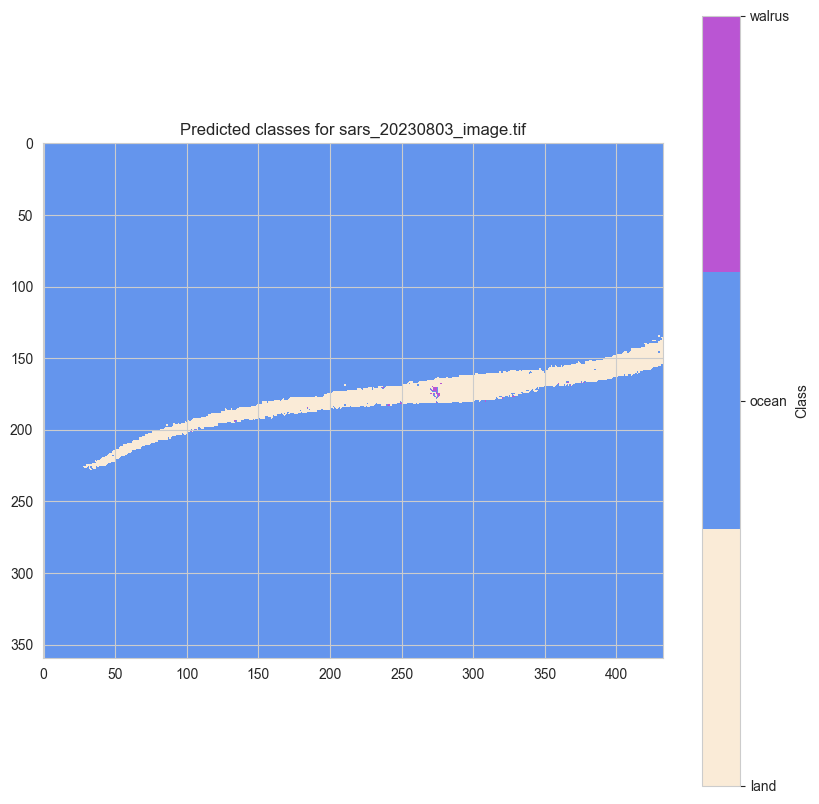

Labels present in tor_20230801_image.tif: ['land', 'ocean', 'walrus']


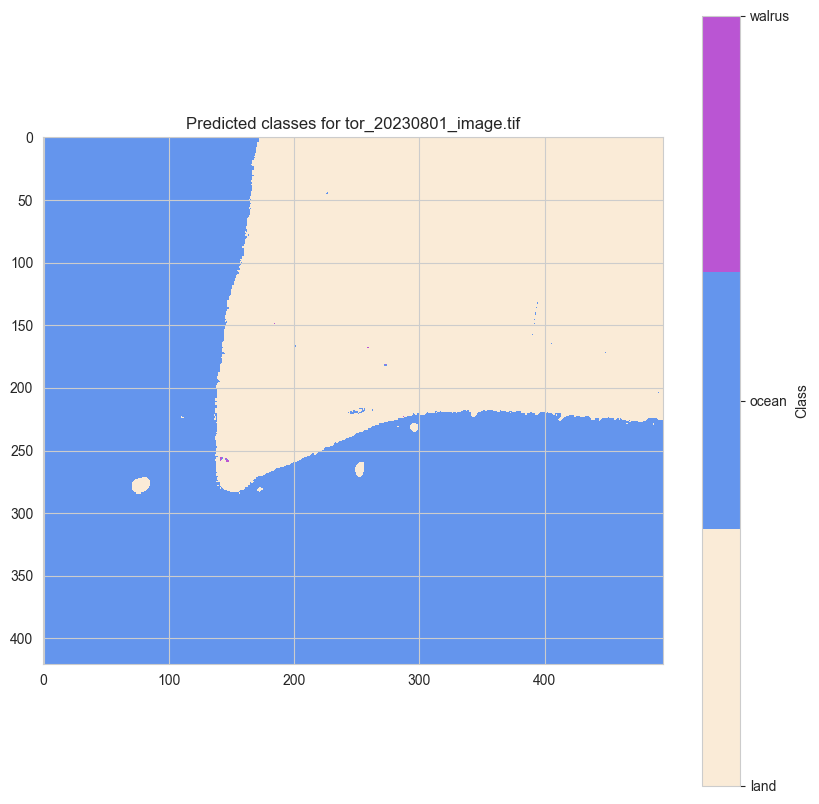

Labels present in tor_20230824_image.tif: ['land', 'ocean', 'walrus']


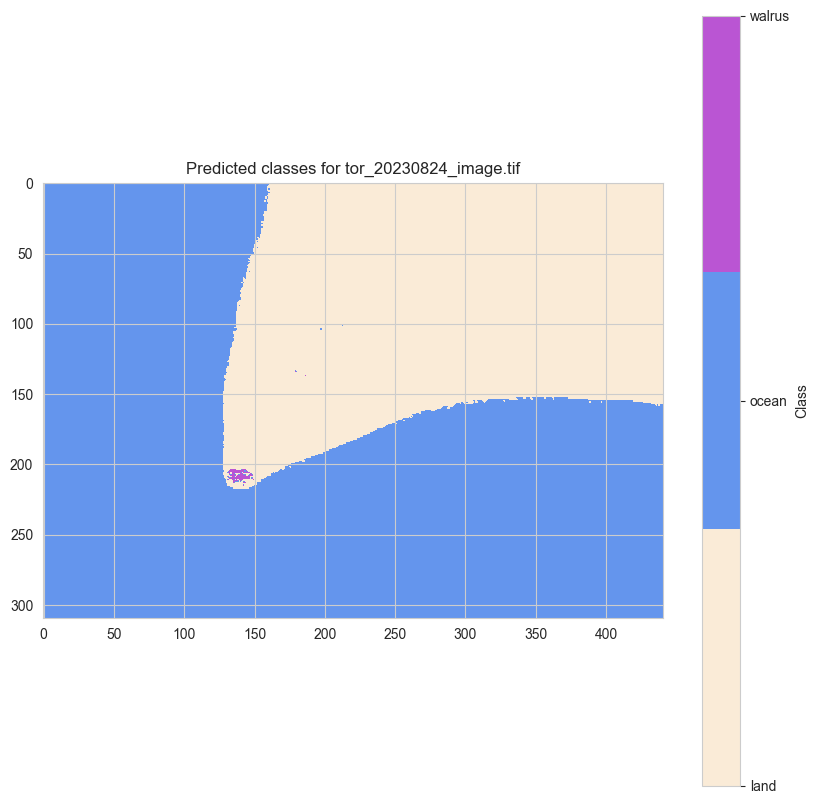

Labels present in tor_20230901_image.tif: ['land', 'ocean', 'walrus']


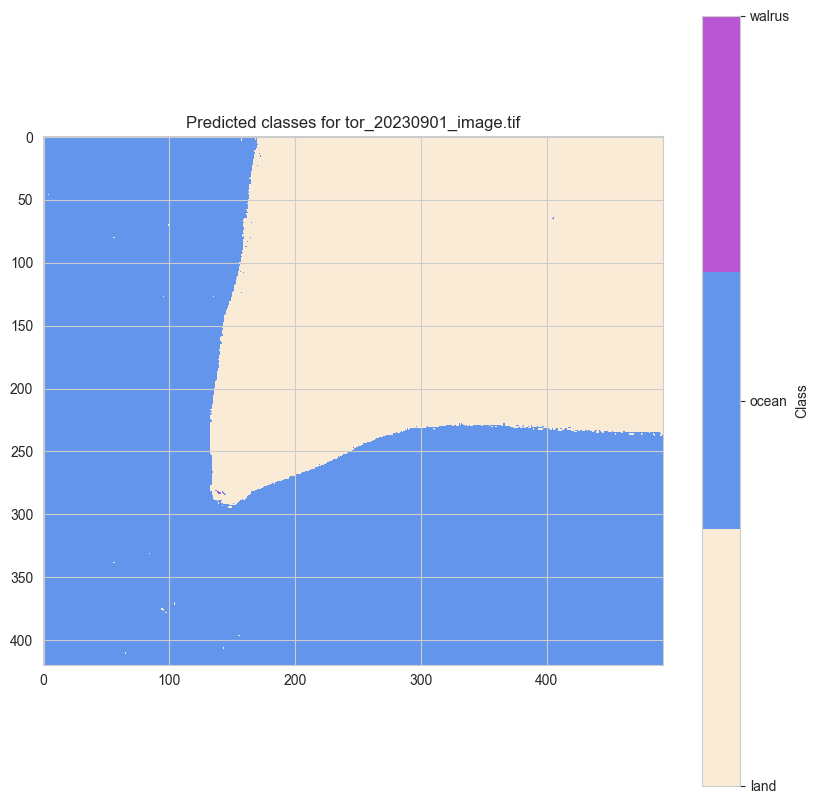

Labels present in tor_20230902_image.tif: ['land', 'ocean', 'walrus']


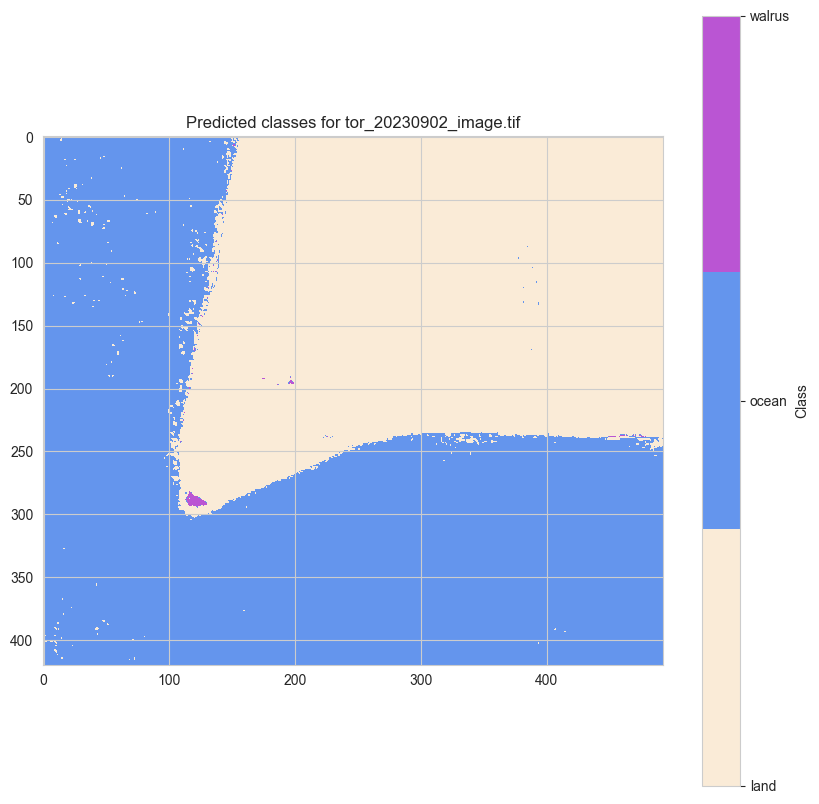

In [31]:
def predict_image_combined(image_path, binary_model, walrus_model):
    with rasterio.open(image_path) as src:
        image = src.read()
        height, width = image.shape[1], image.shape[2]
        
        # Reshape the image data correctly
        image_ocean = image[3:].reshape(5, -1).T
        image_walrus = image[:5].reshape(5, -1).T
        
        # Predict ocean vs. not ocean
        ocean_predictions = binary_model.predict(image_ocean)
        
        # Predict walrus vs. land for non-ocean pixels
        land_mask = ocean_predictions != combined_le.transform(['ocean'])[0]
        walrus_predictions = np.zeros_like(ocean_predictions)
        walrus_predictions[land_mask] = walrus_model.predict(image_walrus[land_mask])
        
        # Combine predictions
        combined_predictions = np.where(land_mask, walrus_predictions, ocean_predictions)
        
        return combined_predictions.reshape((height, width))

# Predict classes for images
predicted_images = {}
for image_path in file_pairs.keys():
    predicted_images[image_path] = predict_image_combined(image_path, binary_model, walrus_model)

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(combined_le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(combined_le.classes_)), label='Class')
    cbar.ax.set_yticklabels([combined_le.classes_[i] for i in range(len(combined_le.classes_))])
    
    # Highlight the labels present in the current image
    present_labels = [combined_le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()